# Install Needed Packages

In [2]:

# install packages used in YOLO model
! pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.8 MB/s eta 0:00:00


In [3]:
# check model
import ultralytics
ultralytics.checks()

Ultralytics 8.3.191 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.0/107.7 GB disk)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Analytics

In [ ]:
import kagglehub
# from kagglehub import KaggleDatasetAdapter # Not needed for dataset_download

# Set the handle for the dataset
dataset_handle = "kronomy/helmet-dataset-by-osf-lite"

# Download the latest version of the dataset
# This will download the entire dataset to a local path
try:
  path = kagglehub.dataset_download(dataset_handle)
  print(f"Dataset downloaded to: {path}")
except Exception as e:
  print(f"Error downloading dataset: {e}")
  path = None # Set path to None if download fails for subsequent checks

Dataset downloaded to: /kaggle/input/helmet-dataset-by-osf-lite


In [ ]:
import os
import numpy as np

# Path to preprocessed YOLO annotations
preprocessed_data_path = '/content/drive/My Drive/dataset/preprocessed_data/yolo_annotations/'

# Load the training and validation data (annotations)
train_annotations = []
val_annotations = []
test_annotations = []

# Load training annotations from subdirectories
train_data_dir = os.path.join(preprocessed_data_path, 'train')
for subdir, _, files in os.walk(train_data_dir):
    for file in files:
        if file.endswith('.txt'):
            with open(os.path.join(subdir, file), 'r') as f:
                train_annotations.append(f.readlines())

# Load validation annotations from subdirectories
val_data_dir = os.path.join(preprocessed_data_path, 'val')
for subdir, _, files in os.walk(val_data_dir):
    for file in files:
        if file.endswith('.txt'):
            with open(os.path.join(subdir, file), 'r') as f:
                val_annotations.append(f.readlines())

# Load test annotations from subdirectories
test_data_dir = os.path.join(preprocessed_data_path, 'test')
for subdir, _, files in os.walk(test_data_dir):
    for file in files:
        if file.endswith('.txt'):
            with open(os.path.join(subdir, file), 'r') as f:
                test_annotations.append(f.readlines())


print(f"Loaded {len(train_annotations)} training annotations.")
print(f"Loaded {len(val_annotations)} validation annotations.")
print(f"Loaded {len(test_annotations)} test annotations.")

# Load the data description
try:
    with open('/content/drive/My Drive/dataset/preprocessed_data/preprocessed_data_description.txt', 'r') as f:
        data_description = f.read()
    print("\nData Description:")
    print(data_description)
except FileNotFoundError:
    print("\nError: Data description file not found.")

Loaded 973 training annotations.
Loaded 136 validation annotations.
Loaded 275 test annotations.

Data Description:

Dataset: HELMET Dataset

Original Data Locations (Downloaded from Kaggle):
- Base Dataset Path: /root/.cache/kagglehub/datasets/kronomy/helmet-dataset-by-osf-lite/versions/1/helmet-dataset (This is the local path where the dataset was downloaded by kagglehub)
- Annotation Files (CSV): /root/.cache/kagglehub/datasets/kronomy/helmet-dataset-by-osf-lite/versions/1/helmet-dataset/annotation/annotation
- Data Split File (CSV): /root/.cache/kagglehub/datasets/kronomy/helmet-dataset-by-osf-lite/versions/1/helmet-dataset/data_split.csv (Note: This file was used for initial understanding, but a custom split was applied.)

Preprocessed Data Output Locations (Saved to Google Drive):
- Base Save Directory: /content/drive/My Drive/dataset/preprocessed_data
- YOLO Annotations: /content/drive/My Drive/dataset/preprocessed_data/yolo_annotations (Saved as text files (.txt) with one file 

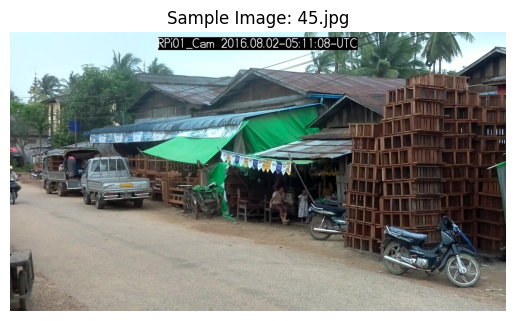

In [ ]:
# Path to the extracted images
images_path = '/kaggle/input/helmet-dataset-by-osf-lite/helmet-dataset/images'

import os
import cv2
from matplotlib import pyplot as plt

# List files in the images directory to find a sample image, searching in subdirectories
image_files = []
for subdir, _, files in os.walk(images_path):
    for file in files:
        if file.endswith('.jpg'):
            image_files.append(os.path.join(subdir, file))

if image_files:
    # Take the first image file as a sample
    sample_image_path = image_files[0]
    sample_image_name = os.path.basename(sample_image_path)

    # Load the image
    sample_image = cv2.imread(sample_image_path)

    if sample_image is not None:
        # Convert the image from BGR to RGB for displaying with Matplotlib
        sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

        # Display the image
        plt.imshow(sample_image_rgb)
        plt.title(f"Sample Image: {sample_image_name}")
        plt.axis('off') # Hide axes
        plt.show()
    else:
        print(f"Error: Could not load image from {sample_image_path}")
else:
    print(f"No image files found in {images_path}")

In [ ]:
import os
import shutil

# Paths defined in previous cells
preprocessed_data_path = '/content/drive/My Drive/dataset/preprocessed_data/yolo_annotations/'
images_path = '/kaggle/input/helmet-dataset-by-osf-lite/helmet-dataset/images' # Use the base images path

# Create new directories for YOLO training, validation, and test images and labels
yolo_train_dir = '/content/drive/My Drive/dataset/data/yolo_train/train'
yolo_val_dir = '/content/drive/My Drive/dataset/data/yolo_train/val'
yolo_test_dir = '/content/drive/My Drive/dataset/data/yolo_train/test'


os.makedirs(yolo_train_dir, exist_ok=True)
os.makedirs(yolo_val_dir, exist_ok=True)
os.makedirs(yolo_test_dir, exist_ok=True)


# Create mappings from image path to annotation path
train_image_annotation_map = {}
val_image_annotation_map = {}
test_image_annotation_map = {}


# Build mapping for training data and copy images and labels
train_data_dir = os.path.join(preprocessed_data_path, 'train')
print(f"Processing training data from: {train_data_dir}")
for subdir, _, files in os.walk(train_data_dir):
    for file in files:
        if file.endswith('.txt'):
            annotation_path = os.path.join(subdir, file)
            # Extract the video sequence and frame ID from the annotation path
            # Assuming the structure is like: .../yolo_annotations/train/video_sequence/frame_id.txt
            parts = subdir.split(os.sep)
            if len(parts) >= 2:
                video_sequence = parts[-1]
                frame_id = file.replace('.txt', '')
                # Construct the corresponding image path by searching in images_path subdirectories
                image_path = None
                for root, _, img_files in os.walk(images_path):
                    if f'{frame_id}.jpg' in img_files and video_sequence in root:
                        image_path = os.path.join(root, f'{frame_id}.jpg')
                        break # Found the image, no need to search further

                if image_path and os.path.exists(image_path):
                    train_image_annotation_map[image_path] = annotation_path
                    # Create subdirectory in the training destination for images and labels
                    train_subdir = os.path.join(yolo_train_dir, video_sequence)
                    os.makedirs(train_subdir, exist_ok=True)


                    # Copy the image to the new training subdirectory
                    dest_image_path = os.path.join(train_subdir, f'{frame_id}.jpg') # Use frame_id as filename
                    shutil.copy(image_path, dest_image_path)

                    # Copy the annotation (label) file to the new training subdirectory
                    dest_label_path = os.path.join(train_subdir, f'{frame_id}.txt') # Use frame_id as filename and .txt extension
                    shutil.copy(annotation_path, dest_label_path)

                else:
                    print(f"Warning: Image file not found for annotation: {annotation_path}. Expected to find at: {image_path}")
            else:
                print(f"Warning: Could not parse video sequence and frame ID from annotation path: {annotation_path}")


# Build mapping for validation data and copy images and labels
val_data_dir = os.path.join(preprocessed_data_path, 'val')
print(f"\nProcessing validation data from: {val_data_dir}")
for subdir, _, files in os.walk(val_data_dir):
    for file in files:
        if file.endswith('.txt'):
            annotation_path = os.path.join(subdir, file)
            # Extract the video sequence and frame ID from the annotation path
            # Assuming the structure is like: .../yolo_annotations/val/video_sequence/frame_id.txt
            parts = subdir.split(os.sep)
            if len(parts) >= 2:
                video_sequence = parts[-1]
                frame_id = file.replace('.txt', '')
                 # Construct the corresponding image path by searching in images_path subdirectories
                image_path = None
                for root, _, img_files in os.walk(images_path):
                    if f'{frame_id}.jpg' in img_files and video_sequence in root:
                        image_path = os.path.join(root, f'{frame_id}.jpg')
                        break # Found the image, no need to search further

                if image_path and os.path.exists(image_path):
                    val_image_annotation_map[image_path] = annotation_path
                    # Create subdirectory in the validation destination for images and labels
                    val_subdir = os.path.join(yolo_val_dir, video_sequence)
                    os.makedirs(val_subdir, exist_ok=True)


                    # Copy the image to the new validation subdirectory
                    dest_image_path = os.path.join(val_subdir, f'{frame_id}.jpg') # Use frame_id as filename
                    shutil.copy(image_path, dest_image_path)

                    # Copy the annotation (label) file to the new validation subdirectory
                    dest_label_path = os.path.join(val_subdir, f'{frame_id}.txt') # Use frame_id as filename and .txt extension
                    shutil.copy(annotation_path, dest_label_path)

                else:
                    print(f"Warning: Image file not found for annotation: {annotation_path}. Expected to find at: {image_path}")
            else:
                 print(f"Warning: Could not parse video sequence and frame ID from annotation path: {annotation_path}")


# Build mapping for test data and copy images and labels
test_data_dir = os.path.join(preprocessed_data_path, 'test')
print(f"\nProcessing test data from: {test_data_dir}")
for subdir, _, files in os.walk(test_data_dir):
    for file in files:
        if file.endswith('.txt'):
            annotation_path = os.path.join(subdir, file)
            # Extract the video sequence and frame ID from the annotation path
            # Assuming the structure is like: .../yolo_annotations/test/video_sequence/frame_id.txt
            parts = subdir.split(os.sep)
            if len(parts) >= 2:
                video_sequence = parts[-1]
                frame_id = file.replace('.txt', '')
                 # Construct the corresponding image path by searching in images_path subdirectories
                image_path = None
                for root, _, img_files in os.walk(images_path):
                    if f'{frame_id}.jpg' in img_files and video_sequence in root:
                        image_path = os.path.join(root, f'{frame_id}.jpg')
                        break # Found the image, no need to search further

                if image_path and os.path.exists(image_path):
                    test_image_annotation_map[image_path] = annotation_path
                    # Create subdirectory in the test destination for images and labels
                    test_subdir = os.path.join(yolo_test_dir, video_sequence)
                    os.makedirs(test_subdir, exist_ok=True)


                    # Copy the image to the new test subdirectory
                    dest_image_path = os.path.join(test_subdir, f'{frame_id}.jpg') # Use frame_id as filename
                    shutil.copy(image_path, dest_image_path)

                    # Copy the annotation (label) file to the new test subdirectory
                    dest_label_path = os.path.join(test_subdir, f'{frame_id}.txt') # Use frame_id as filename and .txt extension
                    shutil.copy(annotation_path, dest_label_path)

                else:
                    print(f"Warning: Image file not found for annotation: {annotation_path}. Expected to find at: {image_path}")
            else:
                 print(f"Warning: Could not parse video sequence and frame ID from annotation path: {annotation_path}")


print(f"\nCreated mapping for {len(train_image_annotation_map)} training images and annotations and copied images and labels.")
print(f"Created mapping for {len(val_image_annotation_map)} validation images and annotations and copied images and labels.")
print(f"Created mapping for {len(test_image_annotation_map)} test images and annotations and copied images and labels.")


# Display a sample mapping (optional)
if train_image_annotation_map:
    sample_image_path = list(train_image_annotation_map.keys())[0]
    print(f"\nSample Training Mapping:")
    print(f"Original Image: {sample_image_path}")
    print(f"Annotation: {train_image_annotation_map[sample_image_path]}")
    # Construct the expected copied image and label paths based on the new structure
    parts = sample_image_path.split(os.sep)
    if len(parts) >= 2:
      video_sequence = parts[-2]
      frame_id = os.path.basename(sample_image_path).replace('.jpg', '')
      copied_image_path = os.path.join(yolo_train_dir, video_sequence, f'{frame_id}.jpg')
      copied_label_path = os.path.join(yolo_train_dir, video_sequence, f'{frame_id}.txt')
      print(f"Copied Image: {copied_image_path}")
      print(f"Copied Label: {copied_label_path}")
    else:
        print("Could not construct sample copied image and label paths for training.")


if val_image_annotation_map:
    sample_image_path = list(val_image_annotation_map.keys())[0]
    print(f"\nSample Validation Mapping:")
    print(f"Original Image: {sample_image_path}")
    print(f"Annotation: {val_image_annotation_map[sample_image_path]}")
    # Construct the expected copied image and label paths based on the new structure
    parts = sample_image_path.split(os.sep)
    if len(parts) >= 2:
      video_sequence = parts[-2]
      frame_id = os.path.basename(sample_image_path).replace('.jpg', '')
      copied_image_path = os.path.join(yolo_val_dir, video_sequence, f'{frame_id}.jpg')
      copied_label_path = os.path.join(yolo_val_dir, video_sequence, f'{frame_id}.txt')
      print(f"Copied Image: {copied_image_path}")
      print(f"Copied Label: {copied_label_path}")

    else:
        print("Could not construct sample copied image and label paths for validation.")

if test_image_annotation_map:
    sample_image_path = list(test_image_annotation_map.keys())[0]
    print(f"\nSample Test Mapping:")
    print(f"Original Image: {sample_image_path}")
    print(f"Annotation: {test_image_annotation_map[sample_image_path]}")
    # Construct the expected copied image and label paths based on the new structure
    parts = sample_image_path.split(os.sep)
    if len(parts) >= 2:
      video_sequence = parts[-2]
      frame_id = os.path.basename(sample_image_path).replace('.jpg', '')
      copied_image_path = os.path.join(yolo_test_dir, video_sequence, f'{frame_id}.jpg')
      copied_label_path = os.path.join(yolo_test_dir, video_sequence, f'{frame_id}.txt')
      print(f"Copied Image: {copied_image_path}")
      print(f"Copied Label: {copied_label_path}")

    else:
        print("Could not construct sample copied image and label paths for test.")

Processing training data from: /content/drive/My Drive/dataset/preprocessed_data/yolo_annotations/train

Processing validation data from: /content/drive/My Drive/dataset/preprocessed_data/yolo_annotations/val

Processing test data from: /content/drive/My Drive/dataset/preprocessed_data/yolo_annotations/test

Created mapping for 898 training images and annotations and copied images and labels.
Created mapping for 136 validation images and annotations and copied images and labels.
Created mapping for 275 test images and annotations and copied images and labels.

Sample Training Mapping:
Original Image: /kaggle/input/helmet-dataset-by-osf-lite/helmet-dataset/images/part_2/Mandalay_1_38/60.jpg
Annotation: /content/drive/My Drive/dataset/preprocessed_data/yolo_annotations/train/Mandalay_1_38/60.txt
Copied Image: /content/drive/My Drive/dataset/data/yolo_train/train/Mandalay_1_38/60.jpg
Copied Label: /content/drive/My Drive/dataset/data/yolo_train/train/Mandalay_1_38/60.txt

Sample Validatio

### Plot Training Images

In [ ]:
# plot training images
import os
import cv2
from matplotlib import pyplot as plt

# Use the mappings created in the previous cell
# train_image_annotation_map
# val_image_annotation_map

# Define the class ID to class name mapping
id2class_map = {
    '0': 'DHelmet',
    '1': 'DNoHelmet',
    '2': 'DHelmetP1Helmet',
    '3': 'DNoHelmetP1NoHelmet',
}

# Define the bounding box color by class
class2color_map = {
    'DHelmet': (0,255,128),
    'DNoHelmet': (255,51,51),
    'DNoHelmetP1NoHelmet': (51,255,255),
    'DHelmetP1NoHelmet': (224,102,255),
}

def get_bbox_and_label(image_path, annotation_path):
    ''' get bbox and label information from label txt files using the provided paths '''

    try:
        with open(annotation_path, 'r') as f:
            lines = f.readlines()
    except FileNotFoundError:
        print(f"Error: Annotation file not found at {annotation_path}")
        return [], []

    # extract bboxes and labels from the label file
    bboxes = []
    labels = []
    for line in lines:
        parts = line.split()
        if len(parts) == 5:
            try:
                class_id = parts[0]
                bbox_coords = [float(n) for n in parts[1:]]
                if class_id in id2class_map:
                    labels.append(id2class_map[class_id])
                    bboxes.append(bbox_coords)
                else:
                    print(f"Warning: Unknown class ID '{class_id}' in annotation file {annotation_path}")
            except ValueError:
                print(f"Warning: Could not parse line in annotation file {annotation_path}: {line}")
        else:
            print(f"Warning: Skipping malformed line in annotation file {annotation_path}: {line}")


    return bboxes, labels

def load_image(image_path):
    # Load image from the provided path
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image # numpy array

def get_bbox_coordinates(img, bbox):
    # reference
    # https://medium.com/@miramnair/yolov7-calculating-the-bounding-box-coordinates-8bab54b97924

    # height, width, and number of channels ( _ => ignored)
    img_height, img_width, _ = img.shape
    x_center, y_center, bbox_width, bbox_height = bbox

    # calculate the coordinates of the bounding box (in pixels)
    x_center_pixel = x_center * img_width
    y_center_pixel = y_center * img_height
    half_width = bbox_width * img_width / 2
    half_height = bbox_height * img_height / 2

    x_min = int(x_center_pixel - half_width)
    y_min = int(y_center_pixel - half_height)
    x_max = int(x_center_pixel + half_width)
    y_max = int(y_center_pixel + half_height)

    return x_min, y_min, x_max, y_max


def plot_image_with_annotations(image_path, annotation_path, class2color_map=class2color_map):
    img = load_image(image_path)
    if img is None:
        return # Exit if image loading failed

    bboxes, labels = get_bbox_and_label(image_path, annotation_path)

    # zip : zipping the lists together into paired values [bbox1, label1], [bbox2, label2]
    for bbox, label in zip(bboxes, labels):

        # get bbox and label info
        color = class2color_map.get(label, (255, 255, 255)) # Default to white if class not in map
        x_min, y_min, x_max, y_max = get_bbox_coordinates(img, bbox)

        # add bounding box with rectangle
        # args : img, top-left coordinates, bottom-right coordinates, color, line thickness.
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 3)

        # add label info
        # args : img, text, starting coordinates, font type, font scale, color, thickness.
        img = cv2.putText(
                img,
                label,
                (x_min, y_min - 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.title(os.path.basename(image_path))
    plt.axis('off') # Hide axes
    plt.show()

Plotting sample training image with annotations:


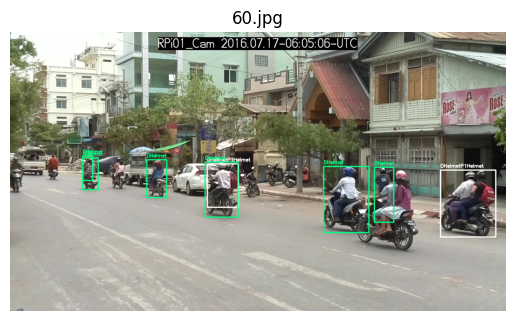

In [ ]:
# Plot a sample training image with annotations
if train_image_annotation_map:
    sample_image_path = list(train_image_annotation_map.keys())[0]
    sample_annotation_path = train_image_annotation_map[sample_image_path]
    print("Plotting sample training image with annotations:")
    plot_image_with_annotations(sample_image_path, sample_annotation_path)
else:
    print("No training images found in the map to plot.")

Plotting another sample training image with annotations:


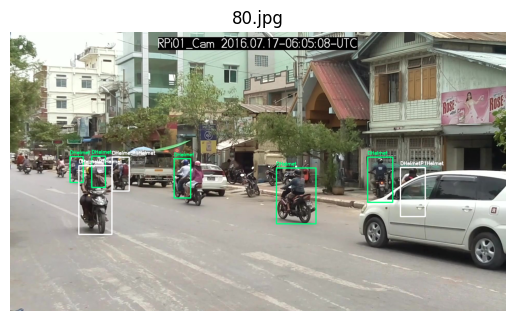

In [ ]:
# Plot another sample training image with annotations
if len(train_image_annotation_map) > 1:
    # Select a different sample image path (e.g., the second one in the list)
    sample_image_path = list(train_image_annotation_map.keys())[1]
    sample_annotation_path = train_image_annotation_map[sample_image_path]
    print("Plotting another sample training image with annotations:")
    plot_image_with_annotations(sample_image_path, sample_annotation_path)
elif train_image_annotation_map:
    print("Only one training image available in the map. Plotting the first one again.")
    sample_image_path = list(train_image_annotation_map.keys())[0]
    sample_annotation_path = train_image_annotation_map[sample_image_path]
    plot_image_with_annotations(sample_image_path, sample_annotation_path)
else:
    print("No training images found in the map to plot.")

###Data Augmentation (Filters / Transformations)

- Geometric transformations (Rotation, Scaling, Translation, Shear)
- Photometric transformations (Brightness, Contrast, Saturation, Hue)
- Mosaic and Mixup (to increase data diversity and handle different backgrounds)

In [ ]:
import os
import cv2
from matplotlib import pyplot as plt
import albumentations as A
import numpy as np

# Define the id2class_map and class2color_map (using the consistent mapping)
id2class_map = {
    '0': 'DHelmet',
    '1': 'DNoHelmet',
    '2': 'DNoHelmetP1NoHelmet',
    '3': 'DHelmetP1NoHelmet',
    '4': 'DNoHelmetP1Helmet',
    '5': 'DNoHelmetP1NoHelmet'
}

# Define the bounding box color by class
class2color_map = {
    'DHelmet': (0,255,128),
    'DNoHelmet': (255,51,51),
    'DNoHelmetP1NoHelmet': (51,255,255),
    'DHelmetP1NoHelmet': (224,102,255),
    'DNoHelmetP1Helmet': (255, 165, 0),
    'DNoHelmetP1NoHelmet': (0, 128, 255)
}


# Define the functions to load image and bounding box/label information using the maps
def get_bbox_and_label_from_map(image_path, train_map, val_map):
    ''' get bbox and label information from label txt files using the provided paths '''
    annotation_path = train_map.get(image_path) or val_map.get(image_path)
    if annotation_path is None:
        print(f"Error: Annotation path not found for image: {image_path}")
        return [], []

    try:
        with open(annotation_path, 'r') as f:
            lines = f.readlines()
    except FileNotFoundError:
        print(f"Error: Annotation file not found at {annotation_path}")
        return [], []

    # extract bboxes and labels from the label file
    bboxes = []
    labels = []
    for line in lines:
        parts = line.split()
        if len(parts) == 5:
            try:
                class_id = parts[0]
                bbox_coords = [float(n) for n in parts[1:]]
                if class_id in id2class_map:
                    labels.append(id2class_map[class_id])
                    bboxes.append(bbox_coords)
                else:
                    print(f"Warning: Unknown class ID '{class_id}' in annotation file {annotation_path}")
            except ValueError:
                print(f"Warning: Could not parse line in annotation file {annotation_path}: {line}")
        else:
            print(f"Warning: Skipping malformed line in annotation file {annotation_path}: {line}")

    return bboxes, labels

def load_image_from_path(image_path):
    # Load image from the provided path
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image # numpy array

def get_bbox_coordinates(img, bbox):
    # reference
    # https://medium.com/@miramnair/yolov7-calculating-the-bounding-box-coordinates-8bab54b97924

    # height, width, and number of channels ( _ => ignored)
    img_height, img_width, _ = img.shape
    x_center, y_center, bbox_width, bbox_height = bbox

    # calculate the coordinates of the bounding box (in pixels)
    x_min = int((x_center - bbox_width / 2) * img_width)
    y_min = int((y_center - bbox_height / 2) * img_height)
    x_max = int((x_center + bbox_width / 2) * img_width)
    y_max = int((y_center + bbox_height / 2) * img_height)

    return x_min, y_min, x_max, y_max


def plot_image_with_annotations(image, bboxes, labels, class2color_map=class2color_map):
    img_to_plot = image.copy()
    for bbox, label in zip(bboxes, labels):
        color = class2color_map.get(label, (255, 255, 255))
        x_min, y_min, x_max, y_max = get_bbox_coordinates(img_to_plot, bbox)
        img_to_plot = cv2.rectangle(img_to_plot,(x_min,y_min),(x_max,y_max), color, 3)
        img_to_plot = cv2.putText(
                img_to_plot,
                label,
                (x_min, y_min - 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img_to_plot)
    plt.axis('off')
    plt.show()

# Define a function to load an image and its bounding boxes and labels in the format required by Albumentations
def load_image_and_bboxes_albumentations(image_path, train_map, val_map):
    img = load_image_from_path(image_path)
    bboxes, labels = get_bbox_and_label_from_map(image_path, train_map, val_map)

    # Convert labels to class IDs (Albumentations expects class IDs)
    class_labels = [list(id2class_map.keys())[list(id2class_map.values()).index(label)] for label in labels]

    # Albumentations expects bounding boxes in [x_min, y_min, x_max, y_max] format (normalized)
    # We have [x_center, y_center, width, height] normalized. Need to convert.
    img_height, img_width, _ = img.shape
    converted_bboxes = []
    for bbox in bboxes:
        x_center, y_center, bbox_width, bbox_height = bbox
        x_min = (x_center - bbox_width / 2)
        y_min = (y_center - bbox_height / 2)
        x_max = (x_center + bbox_width / 2)
        y_max = (y_center + bbox_height / 2)
        converted_bboxes.append([x_min, y_min, x_max, y_max])


    return img, converted_bboxes, class_labels

# Define a function to plot an augmented image with its transformed bounding boxes and labels
def plot_augmented_image(augmented_img, augmented_bboxes, augmented_class_labels, id2class_map, class2color_map):
    img_height, img_width, _ = augmented_img.shape

    # Convert augmented bboxes back to [x_center, y_center, width, height] normalized for plotting function
    yolo_bboxes = []
    for bbox in augmented_bboxes:
        x_min, y_min, x_max, y_max = bbox
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        width = (x_max - x_min)
        height = (y_max - y_min)
        yolo_bboxes.append([x_center, y_center, width, height])


    img_to_plot = augmented_img.copy()
    for bbox, class_label in zip(yolo_bboxes, augmented_class_labels):
        # Ensure class_label is a string before using it as a key
        label = id2class_map[str(int(class_label))]
        color = class2color_map[label]

        # get bbox coordinates in pixels
        x_min, y_min, x_max, y_max = get_bbox_coordinates(img_to_plot, bbox)

        # add bounding box with rectangle
        augmented_img = cv2.rectangle(img_to_plot,(x_min,y_min),(x_max,y_max), color, 3)

        # add label info
        augmented_img = cv2.putText(
                img_to_plot,
                label,
                (x_min, y_min - 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img_to_plot)
    plt.axis('off') # Hide axes
    plt.show()

# Choose a sample image path from the training map and load the original image and annotations
sample_image_path = None
if train_image_annotation_map:
    sample_image_path = list(train_image_annotation_map.keys())[0]
    print(f"Loading original image and annotations for: {os.path.basename(sample_image_path)}")
    original_img, original_bboxes_alb, original_class_labels = load_image_and_bboxes_albumentations(sample_image_path, train_image_annotation_map, val_image_annotation_map)

    if original_img is None:
        print("Error loading original image.")
else:
    print("No training images found in the map to load a sample.")

Loading original image and annotations for: 100.jpg


Applying Horizontal Flipping to all training images...
Finished applying Horizontal Flipping to 321 training images.

Sample Augmented Image (Horizontal Flip):


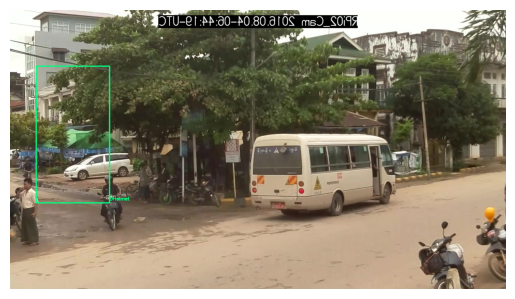

In [ ]:
import albumentations as A # Import Albumentations
import cv2 # Ensure cv2 is imported
from matplotlib import pyplot as plt # Ensure pyplot is imported
import os # Ensure os is imported
import numpy as np # Ensure numpy is imported

# Assuming id2class_map and class2color_map are defined in a previous cell
# Assuming load_image_and_bboxes_albumentations and plot_augmented_image are defined in a previous cell
# Assuming sample_image_path, train_image_annotation_map, val_image_annotation_map are available

# Define the augmentation pipeline
# Horizontal Flipping
horizontal_flip_augmentation = A.Compose([
    A.HorizontalFlip(p=1.0), # p=1.0 means always apply horizontal flip
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'])) # Use pascal_voc format for Albumentations input


# List to store augmented data
augmented_training_data = []

print("Applying Horizontal Flipping to all training images...")

# Iterate through all training images
if train_image_annotation_map:
    for image_path, annotation_path in train_image_annotation_map.items():
        # Load original image and annotations in Albumentations format
        original_img, original_bboxes_alb, original_class_labels = load_image_and_bboxes_albumentations(image_path, train_image_annotation_map, val_image_annotation_map) # Need to pass both maps to helper

        if original_img is not None:
            # Convert bounding boxes to Pascal VOC format for Albumentations input
            original_bboxes_pascal_voc = []
            img_height, img_width, _ = original_img.shape
            for bbox in original_bboxes_alb:
                x_min, y_min, x_max, y_max = bbox
                original_bboxes_pascal_voc.append([x_min * img_width, y_min * img_height, x_max * img_width, y_max * img_height])

            # Convert class labels to list of strings for label_fields
            original_class_labels_str = [str(int(c)) for c in original_class_labels]

            try:
                # Apply the augmentation
                flipped = horizontal_flip_augmentation(image=original_img, bboxes=original_bboxes_pascal_voc, class_labels=original_class_labels_str)
                augmented_img = flipped['image']
                augmented_bboxes_alb = flipped['bboxes']
                augmented_class_labels_int = [int(c) for c in flipped['class_labels']] # Convert labels back to integers


                # Convert augmented bboxes back to YOLO format [x_c, y_c, w, h] normalized for storage
                augmented_bboxes_yolo = []
                aug_img_height, aug_img_width, _ = augmented_img.shape
                for bbox in augmented_bboxes_alb:
                    x_min, y_min, x_max, y_max = bbox
                    # Normalize to the augmented image size
                    x_c = ((x_min + x_max) / 2) / aug_img_width
                    y_c = ((y_min + y_max) / 2) / aug_img_height
                    w = (x_max - x_min) / aug_img_width
                    h = (y_max - y_min) / aug_img_height
                    augmented_bboxes_yolo.append([x_c, y_c, w, h])

                # Store the augmented data
                augmented_training_data.append({
                    'image_path': image_path, # Keep track of the original image path
                    'augmented_image': augmented_img,
                    'augmented_bboxes_yolo': augmented_bboxes_yolo,
                    'augmented_class_labels': augmented_class_labels_int
                })

            except Exception as e:
                print(f"Warning: Error applying Horizontal Flipping to image {image_path}: {e}. Skipping augmentation for this image.")

    print(f"Finished applying Horizontal Flipping to {len(augmented_training_data)} training images.")

else:
    print("No training images found in the map to apply augmentation.")

# The augmented_training_data list now contains all the augmented images and their labels, ready to be saved.
# Example of how you might save the first augmented image (optional):
if augmented_training_data:
    sample_augmented_data = augmented_training_data[0]
    sample_augmented_img = sample_augmented_data['augmented_image']
    sample_augmented_bboxes = sample_augmented_data['augmented_bboxes_yolo']
    sample_augmented_labels = sample_augmented_data['augmented_class_labels']

    print("\nSample Augmented Image (Horizontal Flip):")
    plot_augmented_image(sample_augmented_img, sample_augmented_bboxes, sample_augmented_labels, id2class_map, class2color_map)

/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Applying Color Jitter to all images in augmented_training_data...
Finished applying Color Jitter to 321 images.

Sample Augmented Image (Horizontal Flip + Color Jitter):


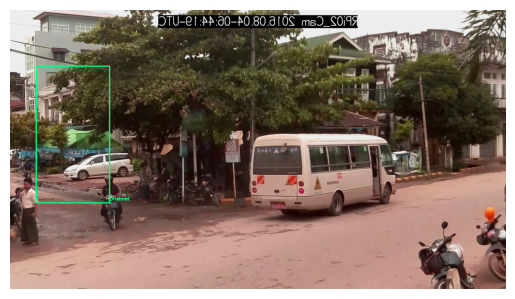

In [ ]:
import albumentations as A # Import Albumentations
import cv2 # Ensure cv2 is imported
from matplotlib import pyplot as plt # Ensure pyplot is imported
import os # Ensure os is imported
import numpy as np # Ensure numpy is imported

# Assuming id2class_map and class2color_map are defined in a previous cell
# Assuming plot_augmented_image is defined in a previous cell
# Assuming augmented_training_data is available from cell ABlwP8V1CLBh

# Define the Albumentations pipeline for applying Color Jitter
# We set p=1.0 to always apply Color Jitter
color_jitter_only_augmentation = A.Compose([
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1.0),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'])) # Use pascal_voc for consistency


print("Applying Color Jitter to all images in augmented_training_data...")

# Check if augmented_training_data is available
if 'augmented_training_data' in locals() and augmented_training_data:
    # Iterate through the augmented_training_data list
    for i, augmented_data_item in enumerate(augmented_training_data):
        # Get the image, bboxes (YOLO format), and labels from the current item
        current_img = augmented_data_item['augmented_image']
        current_bboxes_yolo = augmented_data_item['augmented_bboxes_yolo']
        current_class_labels_int = augmented_data_item['augmented_class_labels']

        # Convert current YOLO bboxes to Pascal VOC pixels for Albumentations input
        current_bboxes_pascal_voc = []
        img_height, img_width, _ = current_img.shape
        for bbox in current_bboxes_yolo:
            x_c, y_c, w, h = bbox
            x_min = (x_c - w/2) * img_width
            y_min = (y_c - h/2) * img_height
            x_max = (x_c + w/2) * img_width
            y_max = (y_c + h/2) * img_height
            current_bboxes_pascal_voc.append([x_min, y_min, x_max, y_max])

        # Convert class labels to list of strings for label_fields
        current_class_labels_str = [str(c) for c in current_class_labels_int]

        try:
            # Apply the Color Jitter augmentation
            color_jittered = color_jitter_only_augmentation(image=current_img, bboxes=current_bboxes_pascal_voc, class_labels=current_class_labels_str)

            # Update the augmented_training_data list with the Color Jittered image
            # Bounding boxes and labels are not changed by Color Jitter, but Albumentations returns them
            # in the specified output format (pascal_voc pixels in this case).
            # We need to convert them back to YOLO format normalized for consistency in the list.
            color_jittered_img = color_jittered['image']
            color_jittered_bboxes_pascal_voc = color_jittered['bboxes']
            color_jittered_class_labels_str = color_jittered['class_labels']

            # Convert augmented bboxes from Pascal VOC pixels back to YOLO format [x_c, y_c, w, h] normalized
            color_jittered_bboxes_yolo = []
            aug_img_height, aug_img_width, _ = color_jittered_img.shape
            for bbox in color_jittered_bboxes_pascal_voc:
                x_min, y_min, x_max, y_max = bbox
                x_c = ((x_min + x_max) / 2) / aug_img_width
                y_c = ((y_min + y_max) / 2) / aug_img_height
                w = (x_max - x_min) / aug_img_width
                h = (y_max - y_min) / aug_img_height
                 # Clamp normalized coordinates to be within [0, 1]
                x_c = np.clip(x_c, 0, 1)
                y_c = np.clip(y_c, 0, 1)
                w = np.clip(w, 0, 1)
                h = np.clip(h, 0, 1)
                color_jittered_bboxes_yolo.append([x_c, y_c, w, h])

            # Convert class labels back to integers for consistency in the list
            color_jittered_class_labels_int = [int(c) for c in color_jittered_class_labels_str]


            # Update the item in the augmented_training_data list
            augmented_training_data[i]['augmented_image'] = color_jittered_img
            augmented_training_data[i]['augmented_bboxes_yolo'] = color_jittered_bboxes_yolo # Bboxes should be the same, but updated format
            augmented_training_data[i]['augmented_class_labels'] = color_jittered_class_labels_int # Labels should be the same, but updated format


        except Exception as e:
            print(f"Warning: Error applying Color Jitter to image {augmented_data_item['image_path']}: {e}. Skipping augmentation for this image.")

    print(f"Finished applying Color Jitter to {len(augmented_training_data)} images.")

    # Optional: Plot a sample augmented image after Color Jitter
    if augmented_training_data:
        sample_augmented_data = augmented_training_data[0]
        sample_augmented_img = sample_augmented_data['augmented_image']
        sample_augmented_bboxes = sample_augmented_data['augmented_bboxes_yolo']
        sample_augmented_labels = sample_augmented_data['augmented_class_labels']

        print("\nSample Augmented Image (Horizontal Flip + Color Jitter):")
        plot_augmented_image(sample_augmented_img, sample_augmented_bboxes, sample_augmented_labels, id2class_map, class2color_map)

else:
    print("No augmented training data found in 'augmented_training_data'. Please run cell ABlwP8V1CLBh first.")

In [ ]:
import os
import cv2
import numpy as np
import shutil # Import shutil for copying original validation data

# Assuming augmented_training_data is available from cell ffBwldUyCNcp (contains Horizontal Flip + Color Jitter)
# Assuming val_image_annotation_map is available from previous steps
# Assuming id2class_map is available for validation label saving

# Define the output directories
augmented_train_dir = '/content/drive/My Drive/dataset/data/augmented_train'
augmented_val_dir = '/content/drive/My Drive/dataset/data/augmented_val'

# Create the base output directories if they don't exist
os.makedirs(augmented_train_dir, exist_ok=True)
os.makedirs(augmented_val_dir, exist_ok=True)

print(f"Saving augmented training data to: {augmented_train_dir}")
print(f"Saving validation data to: {augmented_val_dir}")

# Save Augmented Training Data (Horizontal Flip + Color Jitter)
if 'augmented_training_data' in locals() and augmented_training_data:
    print("\nSaving augmented training images and labels...")
    for i, augmented_data in enumerate(augmented_training_data):
        original_image_path = augmented_data['image_path']
        augmented_img = augmented_data['augmented_image']
        augmented_bboxes_yolo = augmented_data['augmented_bboxes_yolo']
        augmented_class_labels = augmented_data['augmented_class_labels']

        # Extract video sequence and frame ID from the original image path
        # Assuming the original image path structure is like: .../extracted_images/video_sequence/frame_id.jpg
        parts = original_image_path.split(os.sep)
        if len(parts) >= 2:
            video_sequence = parts[-2]
            frame_id = os.path.splitext(parts[-1])[0]

            # Create subdirectory for the video sequence in the augmented train directory
            train_subdir = os.path.join(augmented_train_dir, video_sequence)
            os.makedirs(train_subdir, exist_ok=True)

            # Construct the filename for the augmented image and label file (using original frame ID)
            save_filename_base = f"{frame_id}_hf_cj" # Suffix for Horizontal Flip + Color Jitter

            # Save the augmented image
            img_save_path = os.path.join(train_subdir, f"{save_filename_base}.jpg")
            # OpenCV expects BGR format for saving
            augmented_img_bgr = cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(img_save_path, augmented_img_bgr)

            # Save the augmented label file in YOLO format
            label_save_path = os.path.join(train_subdir, f"{save_filename_base}.txt")
            with open(label_save_path, 'w') as f:
                for bbox, class_label in zip(augmented_bboxes_yolo, augmented_class_labels):
                    # YOLO format: class_id center_x center_y normalized_width normalized_height
                    f.write(f"{class_label} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n") # Format to 6 decimal places
        else:
            print(f"Warning: Could not parse video sequence and frame ID from original image path: {original_image_path}. Skipping.")


    print(f"Successfully saved {len(augmented_training_data)} augmented training images and label files.")
else:
    print("No augmented training data found in 'augmented_training_data'. Please run the augmentation cells first.")


# Save Validation Data (Original - no augmentation)
if 'val_image_annotation_map' in locals() and val_image_annotation_map:
    print("\nSaving original validation images and labels...")
    for image_path, annotation_path in val_image_annotation_map.items():
        # Extract video sequence and frame ID from the original image path
        # Assuming the original image path structure is like: .../extracted_images/video_sequence/frame_id.jpg
        parts = image_path.split(os.sep)
        if len(parts) >= 2:
            video_sequence = parts[-2]
            frame_id = os.path.splitext(parts[-1])[0]

            # Create subdirectory for the video sequence in the augmented val directory
            val_subdir = os.path.join(augmented_val_dir, video_sequence)
            os.makedirs(val_subdir, exist_ok=True)

            # Construct the destination paths within the subdirectory
            dest_image_path = os.path.join(val_subdir, f'{frame_id}.jpg')
            dest_label_path = os.path.join(val_subdir, f'{frame_id}.txt')

            # Copy the original image file
            if os.path.exists(image_path):
                shutil.copy(image_path, dest_image_path)
            else:
                print(f"Warning: Original image file not found at {image_path}. Cannot copy.")

            # Copy the original annotation (label) file
            if os.path.exists(annotation_path):
                shutil.copy(annotation_path, dest_label_path)
            else:
                print(f"Warning: Original annotation file not found at {annotation_path}. Cannot copy label.")
        else:
             print(f"Warning: Could not parse video sequence and frame ID from image path: {image_path}. Skipping.")


    print(f"Successfully saved {len(val_image_annotation_map)} validation images and label files.")
else:
    print("No validation image annotation map found. Cannot save validation data.")

print("\nFinished processing and saving training and validation data.")

Saving augmented training data to: /content/drive/My Drive/dataset/data/augmented_train
Saving validation data to: /content/drive/My Drive/dataset/data/augmented_val

Saving augmented training images and labels...
Successfully saved 321 augmented training images and label files.

Saving original validation images and labels...
Successfully saved 37 validation images and label files.

Finished processing and saving training and validation data.


# Load YOLO8 Model

In [4]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLOv8n model
model = YOLO('yolov8n.pt')

# Display model information (optional)
model.info()

YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(129, 3157200, 0, 8.8575488)

## Set yaml & Model Training

In [5]:
import yaml
import os

data = {
    'train': '/content/drive/My Drive/dataset/data/yolo_train/train',
    'val': '/content/drive/My Drive/dataset/data/yolo_train/val',
    'nc': 4, # Number of classes
    'names': [
        'DHelmet',
        'DNoHelmet',
        'DHelmetP1Helmet',
        'DNoHelmetP1NoHelmet',
    ]
}

dir = '/content/'
yaml_filename = 'data.yaml'
yaml_path = os.path.join(dir, yaml_filename)

# Create the directory if it doesn't exist
if not os.path.exists(dir):
    os.makedirs(dir)

# Write the data to the YAML file
with open(yaml_path, 'w') as file:
    yaml.dump(data, file)

print(f"Created YAML file at: {yaml_path}")

# check the content of data.yaml
print("\nContent of data.yaml:")
with open(yaml_path, 'r') as file:
    print(file.read())

Created YAML file at: /content/data.yaml

Content of data.yaml:
names:
- DHelmet
- DNoHelmet
- DHelmetP1Helmet
- DNoHelmetP1NoHelmet
nc: 4
train: /content/drive/My Drive/dataset/data/yolo_train/train
val: /content/drive/My Drive/dataset/data/yolo_train/val



In [ ]:
# disable wandb
os.environ['WANDB_MODE'] = "disabled"

# command to train the YOLOv8 model
model.train(
    # dataset configuration
    data='/content/data.yaml', # (training/validation, images/labels paths, classes num, class names)
    epochs=5,
    workers=1,                        # num of subprocesses used to load data in parallel
    batch=32,
    imgsz=960,
    optimizer='AdamW',
    lr0=0.001,

    augment=True,
    mosaic=1.0,
    # Add photometric distortions (ranges for hsv, scale, etc.)
    hsv_h=0.015, # Hue
    hsv_s=0.7,   # Saturation
    hsv_v=0.4,   # Value
    # Add geometric augmentations
    fliplr=0.5,  # Horizontal flip with 50% probability
    degrees=10,  # Random rotation up to 10 degrees
    shear=5      # Random shear up to 5 degrees
)

'''
Iterate through the dataset for the specified number of epochs,
updating the model's weights to minimize the defined loss functions.

The output in the cell shows the progress of each epoch,
including loss values and evaluation metrics on the validation set.
'''

Ultralytics 8.3.191 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train32, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pr

"\nIterate through the dataset for the specified number of epochs,\nupdating the model's weights to minimize the defined loss functions.\n\nThe output in the cell shows the progress of each epoch,\nincluding loss values and evaluation metrics on the validation set.\n"

In [ ]:
import yaml
import os

# Define the path to the test images directory
train_images_dir = '/content/drive/My Drive/dataset/data/yolo_train/train'
val_images_dir = '/content/drive/My Drive/dataset/data/yolo_train/val'
test_images_dir = '/content/drive/My Drive/dataset/data/yolo_train/test'

# Define the data for the test data.yaml file
# Include dummy paths for 'train' and 'val' to satisfy model.val() requirements
data_test = {
    'train': train_images_dir, # Dummy path (can be any valid directory)
    'val': val_images_dir,   # Dummy path (can be any valid directory)
    'test': test_images_dir,  # Path to the actual test images
    'nc': 4, # Number of classes
    'names': [
        'DHelmet',
        'DNoHelmet',
        'DHelmetP1Helmet',
        'DNoHelmetP1NoHelmet',
    ]
}

# Define the path to save the test data.yaml file
test_yaml_filename = 'data_test.yaml'
test_yaml_path = os.path.join('/content/', test_yaml_filename)

# Create the directory if it doesn't exist (already created /content/ in a previous step, but good practice)
if not os.path.exists('/content/'):
    os.makedirs('/content/')

# Write the data to the test YAML file
with open(test_yaml_path, 'w') as file:
    yaml.dump(data_test, file)

print(f"Created test YAML file at: {test_yaml_path}")

# check the content of data_test.yaml
print("\nContent of data_test.yaml:")
with open(test_yaml_path, 'r') as file:
    print(file.read())


Created test YAML file at: /content/data_test.yaml

Content of data_test.yaml:
names:
- DHelmet
- DNoHelmet
- DHelmetP1Helmet
- DNoHelmetP1NoHelmet
nc: 4
test: /content/drive/My Drive/dataset/data/yolo_train/test
train: /content/drive/My Drive/dataset/data/yolo_train/train
val: /content/drive/My Drive/dataset/data/yolo_train/val



In [ ]:
import numpy as np
# Evaluate the model on the test dataset

print("Evaluating model on the test dataset...")

# Define the path to the test images directory
test_images_dir = '/content/drive/My Drive/dataset/data/yolo_train/test'
test_yaml_path = '/content/data_test.yaml' # Path to the test data.yaml file

# Load the best trained model
#model = YOLO('/content/drive/My Drive/Class/Y3S1/BMDS2133 IP/Image Processing/Assignment/YOLOv8/model/train_lr0.01_batch16_imgsz640_optSGD/weights/best.pt')
model = YOLO('/content/drive/My Drive/model/train_lr0.01_batch16_imgsz640_optSGD/weights/best.pt')

# Use the model.val() method for evaluation.
# We pass the test data.yaml file which specifies the test set path.
results = model.val(
    data=test_yaml_path, # Pass the test data.yaml file
    imgsz=960, # Use the same image size as training
    batch=32,  # Use the same batch size as training
    # No need to specify split='test' when using a data.yaml with only the 'test' key
)

# The 'results' object will contain the evaluation metrics on the test set.
# Access and print relevant metrics from the results object.
print("\n--- Test Set Evaluation Results ---")

# The metrics are typically stored in the 'box' attribute for detection tasks
if hasattr(results, 'box'):
    # Check if the metric is a list or numpy array and print accordingly
    precision = results.box.p
    recall = results.box.r
    map50 = results.box.map50
    map50_95 = results.box.map

    # Function to safely print metrics that might be lists or arrays
    def print_metric(name, value):
        if isinstance(value, (list, np.ndarray)):
            # Assuming the relevant value is the first element if it's a list/array
            if len(value) > 0:
                print(f"{name}: {value[0]:.4f}")
            else:
                print(f"{name}: N/A (empty list/array)")
        else:
            print(f"{name}: {value:.4f}")

    print_metric("Precision (P)", precision)
    print_metric("Recall (R)", recall)
    print_metric("mAP@0.5", map50)
    print_metric("mAP@0.5:0.95", map50_95)

    # Add a note about F1-score and confidence
    print("\nNote on F1-score and Confidence:")
    print("F1-score balances Precision and Recall. The F1-Confidence curve, saved in the run directory, shows how F1 changes with different confidence thresholds.")
    print("You can find the F1-Confidence curve (BoxF1_curve.png) and other performance plots in the results directory:")
    if hasattr(results, 'save_dir'):
        print(f"Results directory: {results.save_dir}")
    else:
         print("Results directory information not available.")

elif hasattr(results, 'results_dict') and isinstance(results.results_dict, dict):
     metrics = results.results_dict
     # Access metrics from the dictionary
     precision = metrics.get('metrics/Precision(B)', float('nan'))
     recall = metrics.get('metrics/Recall(B)', float('nan'))
     map50 = metrics.get('metrics/mAP50(B)', float('nan'))
     map50_95 = metrics.get('metrics/mAP50-95(B)', float('nan'))

     print(f"Precision (P): {precision:.4f}")
     print(f"Recall (R): {recall:.4f}")
     print(f"mAP@0.5: {map50:.4f}")
     print(f"mAP@0.5:0.95: {map50_95:.4f}")

     # Add a note about F1-score and confidence
     print("\nNote on F1-score and Confidence:")
     print("F1-score balances Precision and Recall. The F1-Confidence curve, saved in the run directory, shows how F1 changes with different confidence thresholds.")
     if hasattr(results, 'save_dir'):
        print(f"Results directory: {results.save_dir}")
     else:
         print("Results directory information not available.")

else:
    print("Could not reliably extract evaluation metrics from validation results.")


# The evaluation results (including metrics, confusion matrix, curves) will also be saved
# in a 'val' directory within the run directory (e.g., runs/detect/train22/val or a new run directory if specified).
# print(f"\nEvaluation results saved to: {results.save_dir}") # Already printing this above

Evaluating model on the test dataset...
Ultralytics 8.3.191 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.0 ms, read: 141.7±27.8 MB/s, size: 329.4 KB)
val: Scanning /content/drive/.shortcut-targets-by-id/1iPsSug2nF-JXlduHBhoxf443t6XQz-xG/dataset/data/yolo_train/val/Bago_highway_19.cache... 137 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 137/137 263587.0it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.89it/s 5.6s
                   all        137        338      0.576      0.511      0.475       0.37
               DHelmet         98        187      0.527      0.701       0.58      0.447
             DNoHelmet         35         48      0.568      0.411      0.472      0.353
       DHelmetP1Helmet         49         68      0.478      0.676      0.483      0.372
   DNoHelm

### Training output description:

In [ ]:
"""
Here's a breakdown of the training output:

1. Ultralytics version and environment:
   => The first lines indicate the Ultralytics version, Python version, PyTorch version,
    and the device being used for training (CPU in this case).

2. Engine/trainer parameters:
   => This section lists all the parameters used for training, including the dataset path,
   number of epochs, batch size, optimizer settings, and various augmentation parameters.

3. Model summary:
   => This shows the architecture of the YOLOv8 model, including the number of layers,
   parameters, gradients, and GFLOPs. It also indicates that the model's output layers
   have been adapted to match the 4 classes in your dataset (Overriding model.yaml nc=80 with nc=4).

4. Transfer learning:
   => "Transferred 319/355 items from pretrained weights" indicates that the model is using
   pretrained weights from a larger dataset (like COCO) and adapting them for your specific task.

5. Dataset scanning:
   => The output shows the scanning of your training and validation datasets, indicating the
   number of images and any corrupt images that were ignored.

6. Albumentations:
   => This indicates that data augmentation techniques from the Albumentations library are
   being applied during training to increase the diversity of the training data.

7. Optimizer:
   => Information about the optimizer being used and its learning rate and momentum.

8. Training progress per epoch:

   => This is the main part of the output during training. For each epoch, it shows:
        -> Epoch: The current epoch number.
        -> GPU_mem: The amount of GPU memory being used (0G in this case as it's running on CPU).

        -> box_loss, cls_loss, dfl_loss:
            These are the values of the different loss functions
            being optimized during training (bounding box loss, classification loss, and
            distribution focal loss). You want these values to decrease over epochs.

        -> Instances: The number of instances (objects) detected in the batch.
        -> Size: The image size used for training.

   => Validation metrics per epoch: After each epoch, the model is evaluated on the
      validation set, and the following metrics are reported:
        -> Class: The class name (or 'all' for the average across all classes).
        -> Images: The number of images in the validation set.
        -> Instances: The total number of instances in the validation set.

        -> Box(P, R, mAP50, mAP50-95): These are object detection evaluation metrics:
            > P: Precision - the proportion of correctly detected objects out of all detected objects.
            > R: Recall - the proportion of correctly detected objects out of all actual objects in the ground truth.

            > mAP50: mean Average Precision at an Intersection over Union (IoU) threshold of 0.50.
                      This is a common metric for object detection performance.

            > mAP50-95: mean Average Precision averaged over IoU thresholds from 0.50 to 0.95.
                      This is a more stringent metric that considers detection accuracy across
                      different levels of localization precision.

9. Training duration:
   => The total time taken for training.

10. Model saving:
   => Information about where the best and last trained models are saved (runs/detect/train/weights/best.pt and last.pt).

11. Final validation results:
   => After training is complete, the model is validated one last time, and the final evaluation metrics for each class and the overall metrics are reported.

12. Speed:
   => The time taken for different stages of the detection process (preprocess, inference, postprocess) per image.

13. Results saved to:
   => The directory where all the training results, including plots and metrics, are saved.

"""

### Check Detection Result of Validation Images

In [6]:
# select the best model for checking prediction plot
# the model is saved in best.pt directly after training
# model = YOLO('/content/runs/detect/train8/weights/best.pt')
model = YOLO('/content/drive/My Drive/Class/Y3S1/BMDS2133 IP/Image Processing/Assignment/YOLOv8/model/train_lr0.01_batch16_imgsz640_optSGD/weights/best.pt')


In [7]:
# Define the class ID to class name mapping
id2class_map = {
    '0': 'DHelmet',
    '1': 'DNoHelmet',
    '2': 'DHelmetP1Helmet',
    '3': 'DNoHelmetP1NoHelmet',
}

# Define the bounding box color by class
class2color_map = {
    'DHelmet': (0,255,128),
    'DNoHelmet': (255,51,51),
    'DHelmetP1Helmet': (51,255,255),
    'DNoHelmetP1NoHelmet': (224,102,255),
}


In [49]:
import cv2
from matplotlib import pyplot as plt

# use results from `model.predict()` for plotting
def plot_pred_image(video_sequence, frame_id, yolo_val_images_dir, id2class_map=id2class_map, class2color_map=class2color_map):
    """Plots a predicted image with bounding boxes and labels from YOLO model results."""
    image_path = os.path.join(yolo_val_images_dir, video_sequence, f'{frame_id}.jpg')

    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return

    # get plot elements (bbox, labels) from `predict()` results
    results = model.predict(image_path)
    # first (and only) single image object
    r = results[0]
    # as NumPy array
    img = r.orig_img

    # r.boxes : Boxes object (bounding boxes info)
    # xyxy : Gets the bounding box coordinates in the [x_min, y_min, x_max, y_max] format.
    bboxes = r.boxes.xyxy.tolist()

    # r.boxes.cls : Gets the predicted class IDs as a PyTorch tensor (similar to NumPy n-d array)
    # Ensure class IDs are integers before mapping
    labels = [id2class_map[str(int(c))] for c in r.boxes.cls.tolist()]

    for bbox, label in zip(bboxes, labels):
        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = [int(n) for n in bbox]

        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 3)

        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.title(f"Detection for {video_sequence}/{frame_id}.jpg")
    plt.axis('off') # Hide axes
    plt.show()

Plotting prediction for image: Bago_highway_30/40.jpg

image 1/1 /content/drive/My Drive/dataset/data/yolo_train/test/Bago_highway_30/40.jpg: 544x960 1 DHelmet, 3 DNoHelmets, 246.6ms
Speed: 5.6ms preprocess, 246.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 960)


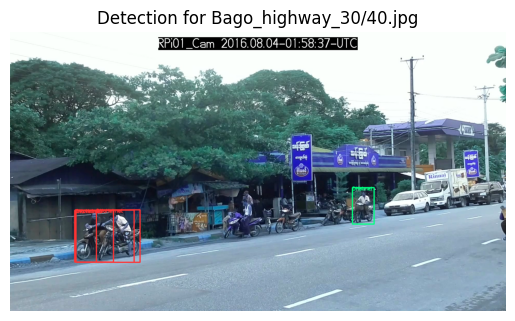

In [50]:
import os

# Define the directory containing the YOLO validation images
yolo_test_images_dir = '/content/drive/My Drive/dataset/data/yolo_train/test'

# Example: Replace with actual video sequence and frame ID from your data
sample_video_sequence = 'Bago_highway_30'  # Example video sequence name
sample_frame_id = '40'                 # Example frame ID

print(f"Plotting prediction for image: {sample_video_sequence}/{sample_frame_id}.jpg")

# Plot the predicted image with annotations
plot_pred_image(sample_video_sequence, sample_frame_id, yolo_test_images_dir)

Original Image:

image 1/1 /content/drive/My Drive/dataset/data/yolo_train/test/Mandalay_1_128/60.jpg: 544x960 14 DHelmets, 370.3ms
Speed: 6.1ms preprocess, 370.3ms inference, 4.9ms postprocess per image at shape (1, 3, 544, 960)


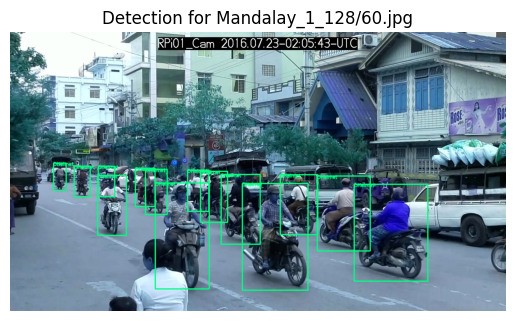

/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


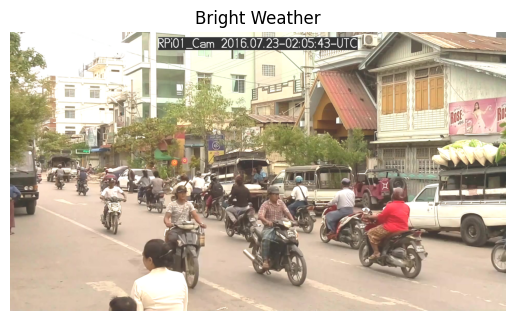

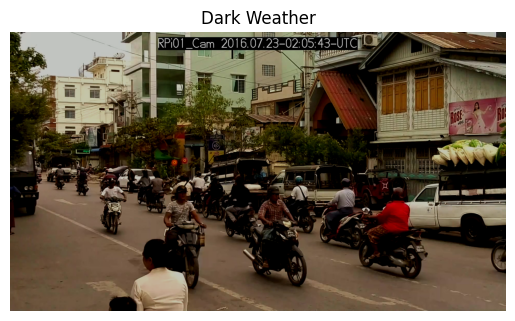

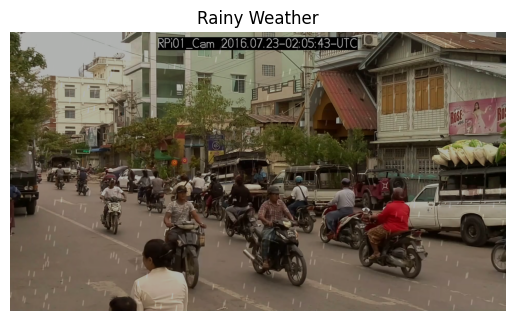


Augmented sample images saved to: /content/drive/My Drive/dataset/augmented_samples


In [51]:
import albumentations as A
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np


# Define the id2class_map and class2color_map (using the consistent mapping)
id2class_map = {
    '0': 'DHelmet',
    '1': 'DNoHelmet',
    '2': 'DHelmetP1Helmet',
    '3': 'DNoHelmetP1NoHelmet',
}

# Define the bounding box color by class
class2color_map = {
    'DHelmet': (0,255,128),
    'DNoHelmet': (255,51,51),
    'DHelmetP1Helmet': (51,255,255),
    'DNoHelmetP1NoHelmet': (224,102,255),
}


# Define the functions to load image and bounding box/label information using the maps
def get_bbox_and_label_from_path(annotation_path):
    ''' get bbox and label information from label txt files using the provided paths '''

    try:
        with open(annotation_path, 'r') as f:
            lines = f.readlines()
    except FileNotFoundError:
        print(f"Error: Annotation file not found at {annotation_path}")
        return [], []

    # extract bboxes and labels from the label file
    bboxes = []
    labels = []
    for line in lines:
        parts = line.split()
        if len(parts) == 5:
            try:
                class_id = parts[0]
                bbox_coords = [float(n) for n in parts[1:]]
                if class_id in id2class_map:
                    labels.append(id2class_map[class_id])
                    bboxes.append(bbox_coords)
                else:
                    print(f"Warning: Unknown class ID '{class_id}' in annotation file {annotation_path}")
            except ValueError:
                print(f"Warning: Could not parse line in annotation file {annotation_path}: {line}")
        else:
            print(f"Warning: Skipping malformed line in annotation file {annotation_path}: {line}")

    return bboxes, labels

def load_image_from_path(image_path):
    # Load image from the provided path
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image # numpy array

def get_bbox_coordinates_pixel(img, bbox):
    # reference
    # https://medium.com/@miramnair/yolov7-calculating-the-bounding-box-coordinates-8bab54b97924

    # height, width, and number of channels ( _ => ignored)
    img_height, img_width, _ = img.shape
    x_center, y_center, bbox_width, bbox_height = bbox

    # calculate the coordinates of the bounding box (in pixels)
    x_min = int((x_center - bbox_width / 2) * img_width)
    y_min = int((y_center - bbox_height / 2) * img_height)
    x_max = int((x_center + bbox_width / 2) * img_width)
    y_max = int((y_center + bbox_height / 2) * img_height)

    return x_min, y_min, x_max, y_max


def plot_image_with_annotations(image, bboxes, labels, title, class2color_map=class2color_map):
    img_to_plot = image.copy()
    for bbox, label in zip(bboxes, labels):
        color = class2color_map.get(label, (255, 255, 255))
        x_min, y_min, x_max, y_max = get_bbox_coordinates_pixel(img_to_plot, bbox)
        img_to_plot = cv2.rectangle(img_to_plot,(x_min,y_min),(x_max,y_max), color, 3)
        img_to_plot = cv2.putText(
                img_to_plot,
                label,
                (x_min, y_min - 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img_to_plot)
    plt.title(title)
    plt.axis('off') # Hide axes
    plt.show()

# Define a function to load an image and its bounding boxes and labels in the format required by Albumentations
def load_image_and_bboxes_albumentations(image_path, annotation_path):
    img = load_image_from_path(image_path)
    bboxes, labels = get_bbox_and_label_from_path(annotation_path)

    if img is None:
        return None, [], []

    # Convert labels to class IDs (Albumentations expects class IDs)
    class_labels = [list(id2class_map.keys())[list(id2class_map.values()).index(label)] for label in labels]

    # Albumentations expects bounding boxes in [x_min, y_min, x_max, y_max] format (normalized)
    # We have [x_center, y_center, width, height] normalized. Need to convert.
    converted_bboxes = []
    for bbox in bboxes:
        x_center, y_center, bbox_width, bbox_height = bbox
        x_min = (x_center - bbox_width / 2)
        y_min = (y_center - bbox_height / 2)
        x_max = (x_center + bbox_width / 2)
        y_max = (y_center + bbox_height / 2)
        converted_bboxes.append([x_min, y_min, x_max, y_max])

    return img, converted_bboxes, class_labels


# Define a function to plot an augmented image with its transformed bounding boxes and labels
def plot_augmented_image(augmented_img, augmented_bboxes_alb, augmented_class_labels, title, id2class_map, class2color_map):
    img_height, img_width, _ = augmented_img.shape

    # Convert augmented bboxes back to [x_center, y_center, width, height] normalized for plotting function
    yolo_bboxes = []
    for bbox in augmented_bboxes_alb:
        x_min, y_min, x_max, y_max = bbox
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        width = (x_max - x_min)
        height = (y_max - y_min)
        yolo_bboxes.append([x_center, y_center, width, height])

    img_to_plot = augmented_img.copy()
    for bbox, class_label in zip(yolo_bboxes, augmented_class_labels):
        # Ensure class_label is a string before using it as a key
        label = id2class_map[str(int(class_label))]
        color = class2color_map[label]

        # get bbox coordinates in pixels
        x_min, y_min, x_max, y_max = get_bbox_coordinates_pixel(img_to_plot, bbox)

        # add bounding box with rectangle
        augmented_img = cv2.rectangle(img_to_plot,(x_min,y_min),(x_max,y_max), color, 3)

        # add label info
        augmented_img = cv2.putText(
                img_to_plot,
                label,
                (x_min, y_min - 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img_to_plot)
    plt.title(title)
    plt.axis('off') # Hide axes
    plt.show()


# Define the directory containing the YOLO validation images
yolo_test_images_dir = '/content/drive/My Drive/dataset/data/yolo_train/test'

# Example: Replace with actual video sequence and frame ID from your data
sample_video_sequence = 'Mandalay_1_128'  # Example video sequence name
sample_frame_id = '60'                 # Example frame ID

# Choose a sample image and annotation path
# You can change these paths to visualize different samples
sample_image_path = '/content/drive/My Drive/dataset/data/yolo_train/test/Mandalay_1_128/60.jpg'
sample_annotation_path = '/content/drive/My Drive/dataset/data/yolo_train/test/Mandalay_1_128/60.txt'

# Load the original image and annotations
original_img, original_bboxes_alb, original_class_labels = load_image_and_bboxes_albumentations(sample_image_path, sample_annotation_path)

if original_img is not None:
    print("Original Image:")
    # Using the plot_pred_image from cell 8sWPOWw048d3 to display original image with predictions
    plot_pred_image(sample_video_sequence, sample_frame_id, yolo_test_images_dir)

    # Define augmentation pipelines for different effects
    # Too Bright
    too_bright_augmentation = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=(0.2, 0.2), contrast_limit=0, p=1.0),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

    # Too Dark
    too_dark_augmentation = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=(-0.23, -0.23), contrast_limit=0, p=1.0),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

    # Rainy
    rainy_augmentation = A.Compose([
        A.RandomRain(blur_value=5, drop_length=20, drop_width=1, drop_color=(200, 200, 200), p=1.0),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

    # Apply and plot each augmentation
    try:
        # Convert original bboxes to Pascal VOC pixel format for Albumentations input
        original_bboxes_pascal_voc = []
        img_height, img_width, _ = original_img.shape
        for bbox in original_bboxes_alb:
            x_min, y_min, x_max, y_max = bbox
            original_bboxes_pascal_voc.append([x_min * img_width, y_min * img_height, x_max * img_width, y_max * img_height])

        # Convert class labels to list of strings for label_fields
        original_class_labels_str = [str(int(c)) for c in original_class_labels]

        # Apply and plot Too Bright
        too_bright_augmented = too_bright_augmentation(image=original_img, bboxes=original_bboxes_pascal_voc, class_labels=original_class_labels_str)
        plot_augmented_image(too_bright_augmented['image'], too_bright_augmented['bboxes'], [int(c) for c in too_bright_augmented['class_labels']], "Bright Weather", id2class_map, class2color_map)

        # Apply and plot Too Dark
        too_dark_augmented = too_dark_augmentation(image=original_img, bboxes=original_bboxes_pascal_voc, class_labels=original_class_labels_str)
        plot_augmented_image(too_dark_augmented['image'], too_dark_augmented['bboxes'], [int(c) for c in too_dark_augmented['class_labels']], "Dark Weather", id2class_map, class2color_map)

        # Apply and plot Rainy
        rainy_augmented = rainy_augmentation(image=original_img, bboxes=original_bboxes_pascal_voc, class_labels=original_class_labels_str)
        plot_augmented_image(rainy_augmented['image'], rainy_augmented['bboxes'], [int(c) for c in rainy_augmented['class_labels']], "Rainy Weather", id2class_map, class2color_map)

        # Save augmented images to Google Drive
        save_dir = '/content/drive/My Drive/dataset/augmented_samples'
        os.makedirs(save_dir, exist_ok=True)

        # Save original image
        original_img_bgr = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(save_dir, 'original_image.jpg'), original_img_bgr)

        # Save Too Bright image
        too_bright_img_bgr = cv2.cvtColor(too_bright_augmented['image'], cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(save_dir, 'bright_weather.jpg'), too_bright_img_bgr)

        # Save Too Dark image
        too_dark_img_bgr = cv2.cvtColor(too_dark_augmented['image'], cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(save_dir, 'dark_weather.jpg'), too_dark_img_bgr)

        # Save Rainy image
        rainy_img_bgr = cv2.cvtColor(rainy_augmented['image'], cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(save_dir, 'rainy_weather.jpg'), rainy_img_bgr)

        print(f"\nAugmented sample images saved to: {save_dir}")


    except Exception as e:
        print(f"Error applying or saving augmentations: {e}")

else:
    print("Error loading sample image or annotations.")

Found 4 augmented sample images in /content/drive/My Drive/dataset/augmented_samples.

Processing: original_image.jpg

image 1/1 /content/drive/My Drive/dataset/augmented_samples/original_image.jpg: 544x960 14 DHelmets, 359.8ms
Speed: 5.5ms preprocess, 359.8ms inference, 5.2ms postprocess per image at shape (1, 3, 544, 960)
Confidence Scores: [0.8873694539070129, 0.8134852647781372, 0.7996428608894348, 0.7804221510887146, 0.754832923412323, 0.7056208252906799, 0.6357576847076416, 0.6094096302986145, 0.6088895201683044, 0.5971952080726624, 0.5678790211677551, 0.5498117804527283, 0.44737666845321655, 0.3616301119327545]


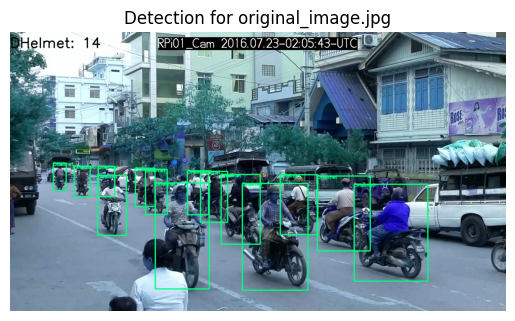


Overall Metrics (based on class counts):
  Overall Precision: 1.0000
  Overall Recall: 0.7778
  Overall F1-score: 0.8750

Processing: bright_weather.jpg

image 1/1 /content/drive/My Drive/dataset/augmented_samples/bright_weather.jpg: 544x960 14 DHelmets, 1 DHelmetP1Helmet, 318.8ms
Speed: 5.1ms preprocess, 318.8ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 960)
Confidence Scores: [0.8473302125930786, 0.7621250748634338, 0.7331726551055908, 0.7304179668426514, 0.7208961248397827, 0.6641557812690735, 0.531680166721344, 0.5312799215316772, 0.4830625355243683, 0.4719078838825226, 0.4646323323249817, 0.4330759346485138, 0.4274178147315979, 0.29830989241600037, 0.256928026676178]


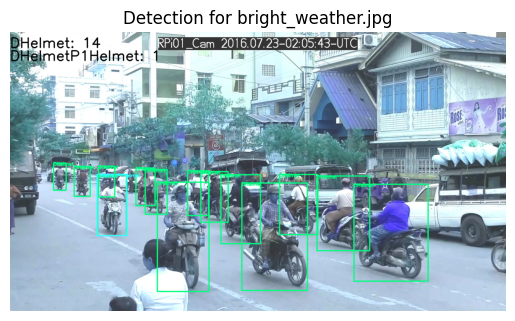


Overall Metrics (based on class counts):
  Overall Precision: 0.9333
  Overall Recall: 0.7778
  Overall F1-score: 0.8485

Processing: dark_weather.jpg

image 1/1 /content/drive/My Drive/dataset/augmented_samples/dark_weather.jpg: 544x960 12 DHelmets, 1 DNoHelmet, 2 DHelmetP1Helmets, 348.8ms
Speed: 5.2ms preprocess, 348.8ms inference, 4.6ms postprocess per image at shape (1, 3, 544, 960)
Confidence Scores: [0.7668505907058716, 0.7343646287918091, 0.6848935484886169, 0.6024374961853027, 0.5366023778915405, 0.5337520837783813, 0.5122343897819519, 0.47595739364624023, 0.4563487470149994, 0.4414820671081543, 0.35012444853782654, 0.33394384384155273, 0.31356281042099, 0.27866512537002563, 0.25031888484954834]


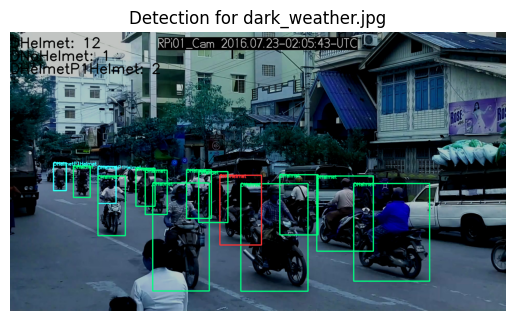


Overall Metrics (based on class counts):
  Overall Precision: 0.8667
  Overall Recall: 1.0000
  Overall F1-score: 0.9286

Processing: rainy_weather.jpg

image 1/1 /content/drive/My Drive/dataset/augmented_samples/rainy_weather.jpg: 544x960 15 DHelmets, 1 DNoHelmet, 379.2ms
Speed: 9.2ms preprocess, 379.2ms inference, 3.9ms postprocess per image at shape (1, 3, 544, 960)
Confidence Scores: [0.902825653553009, 0.8058652281761169, 0.7839159965515137, 0.7727583646774292, 0.748283863067627, 0.6674320101737976, 0.6469053626060486, 0.6112136244773865, 0.5617849230766296, 0.5367968082427979, 0.5317816734313965, 0.4491926431655884, 0.4433855414390564, 0.4323902130126953, 0.36752796173095703, 0.28940945863723755]


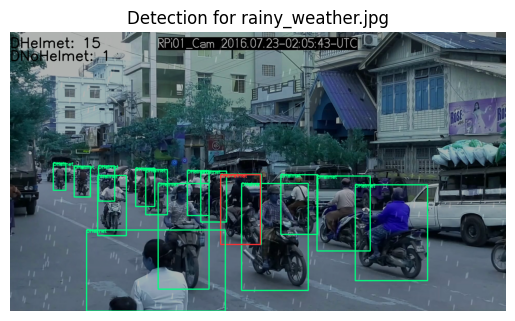


Overall Metrics (based on class counts):
  Overall Precision: 1.0000
  Overall Recall: 1.0000
  Overall F1-score: 1.0000


In [66]:
import os
import cv2
from matplotlib import pyplot as plt
from ultralytics import YOLO
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score # Import necessary metrics
from collections import Counter

# Assuming the model and id2class_map, class2color_map are already defined

# Define the directory where augmented sample images were saved
augmented_samples_dir = '/content/drive/My Drive/dataset/augmented_samples'

# List the saved augmented image files
augmented_image_files = [f for f in os.listdir(augmented_samples_dir) if f.endswith('.jpg')]

# Define a function to calculate and display evaluation metrics using class counts
def calculate_and_display_metrics(true_labels, pred_labels, classes):
    """Calculates and displays precision, recall, and F1-score based on class counts."""

    true_counts = Counter(true_labels)
    pred_counts = Counter(pred_labels)

    # print("\nEvaluation Metrics (based on class counts):")

    # Calculate metrics for each class
    class_metrics = {}
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0

    for cls in classes:
        true_positive = 0
        false_positive = 0
        false_negative = 0

        # To simplify, we'll assume a prediction for a class is a TP if that class
        # is present in the ground truth. This is a simplified approach for comparison
        # and not a standard object detection evaluation.
        # A more rigorous evaluation would involve matching predicted boxes to ground truth boxes (e.g., using IoU).

        # Count true positives (predictions that match a class in the ground truth)
        # and false positives (predictions for classes not in the ground truth)
        for pred_cls in pred_labels:
            if pred_cls == cls and true_counts.get(cls, 0) > 0:
                true_positive += 1
            elif pred_cls == cls and true_counts.get(cls, 0) == 0:
                 false_positive += 1


        # Count false negatives (ground truth classes that were not predicted)
        for true_cls in true_labels:
            if true_cls == cls and pred_counts.get(cls, 0) == 0:
                 false_negative += 1

        total_true_positives += true_positive
        total_false_positives += false_positive
        total_false_negatives += false_negative

        # Calculate Precision, Recall, and F1-score for each class
        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # class_metrics[cls] = {'precision': precision, 'recall': recall, 'f1': f1}

        # print(f"  Class '{cls}':")
        # print(f"    True Positives: {true_positive}")
        # print(f"    False Positives: {false_positive}")
        # print(f"    False Negatives: {false_negative}")
        # print(f"    Precision: {precision:.4f}")
        # print(f"    Recall: {recall:.4f}")
        # print(f"    F1-score: {f1:.4f}")

    # Calculate overall metrics based on counts
    overall_precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
    overall_recall = total_true_positives / (total_true_positives + total_false_negatives) if (total_true_positives + total_false_negatives) > 0 else 0
    overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0

    print("\nOverall Metrics (based on class counts):")
    print(f"  Overall Precision: {overall_precision:.4f}")
    print(f"  Overall Recall: {overall_recall:.4f}")
    print(f"  Overall F1-score: {overall_f1:.4f}")


# use results from `model.predict()` for plotting and getting predictions
def plot_and_predict_image(image_path, id2class_map=id2class_map, class2color_map=class2color_map):
    """Plots a predicted image with bounding boxes and labels from YOLO model results and returns predictions."""
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return None, [], []

    # get plot elements (bbox, labels) from `predict()` results
    results = model.predict(image_path)
    # first (and only) single image object
    r = results[0]
    # as NumPy array
    img = r.orig_img

    # r.boxes : Boxes object (bounding boxes info)
    # xyxy : Gets the bounding box coordinates in the [x_min, y_min, x_max, y_max] format.
    bboxes = r.boxes.xyxy.tolist()

    # r.boxes.cls : Gets the predicted class IDs as a PyTorch tensor (similar to NumPy n-d array)
    # Ensure class IDs are integers before mapping
    predicted_class_ids = [int(c) for c in r.boxes.cls.tolist()]
    predicted_labels = [id2class_map[str(c)] for c in predicted_class_ids]

    # Get confidence scores
    confidence_scores = r.boxes.conf.tolist()
    print("Confidence Scores:", confidence_scores)


    for bbox, label in zip(bboxes, predicted_labels):
        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = [int(n) for n in bbox]

        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 3)

        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )

    # Count the occurrences of each class in the predicted labels
    label_counts = Counter(predicted_labels)

    # Add the class counts as text on the image
    y_offset = 60
    for label, count in label_counts.items():
        text = f"{label}: {count}"
        img = cv2.putText(
            img,
            text,
            (0, y_offset),  # Position the text at the top-left corner
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1.8,  # Increased font scale
            color=(0, 0, 0),  # White color for text
            thickness=4
        )
        y_offset += 50 # Increase offset for next line


    plt.imshow(img)
    plt.title(f"Detection for {os.path.basename(image_path)}")
    plt.axis('off') # Hide axes
    plt.show()

    return predicted_labels # Return predicted labels for metric calculation

# Define the list of all possible classes
all_classes = list(id2class_map.values())

# Get the true labels from the original sample annotation file once
sample_original_annotation_path = '/content/drive/My Drive/dataset/data/yolo_train/test/Mandalay_1_128/60.txt'
true_bboxes, true_labels = get_bbox_and_label_from_path(sample_original_annotation_path)

if augmented_image_files:
    print(f"Found {len(augmented_image_files)} augmented sample images in {augmented_samples_dir}.")


    # Iterate through each augmented image and make a prediction
    for image_filename in augmented_image_files:
        image_path = os.path.join(augmented_samples_dir, image_filename)

        print(f"\nProcessing: {image_filename}")

        # Plot the predicted image and get the predicted labels
        predicted_labels = plot_and_predict_image(image_path)


        if predicted_labels is not None:
             # Calculate and display metrics using the true labels from the original image
            calculate_and_display_metrics(true_labels, predicted_labels, all_classes)

else:
    print(f"No augmented sample images found in {augmented_samples_dir}.")

### Visualize Model Performance

Displaying: confusion_matrix.png


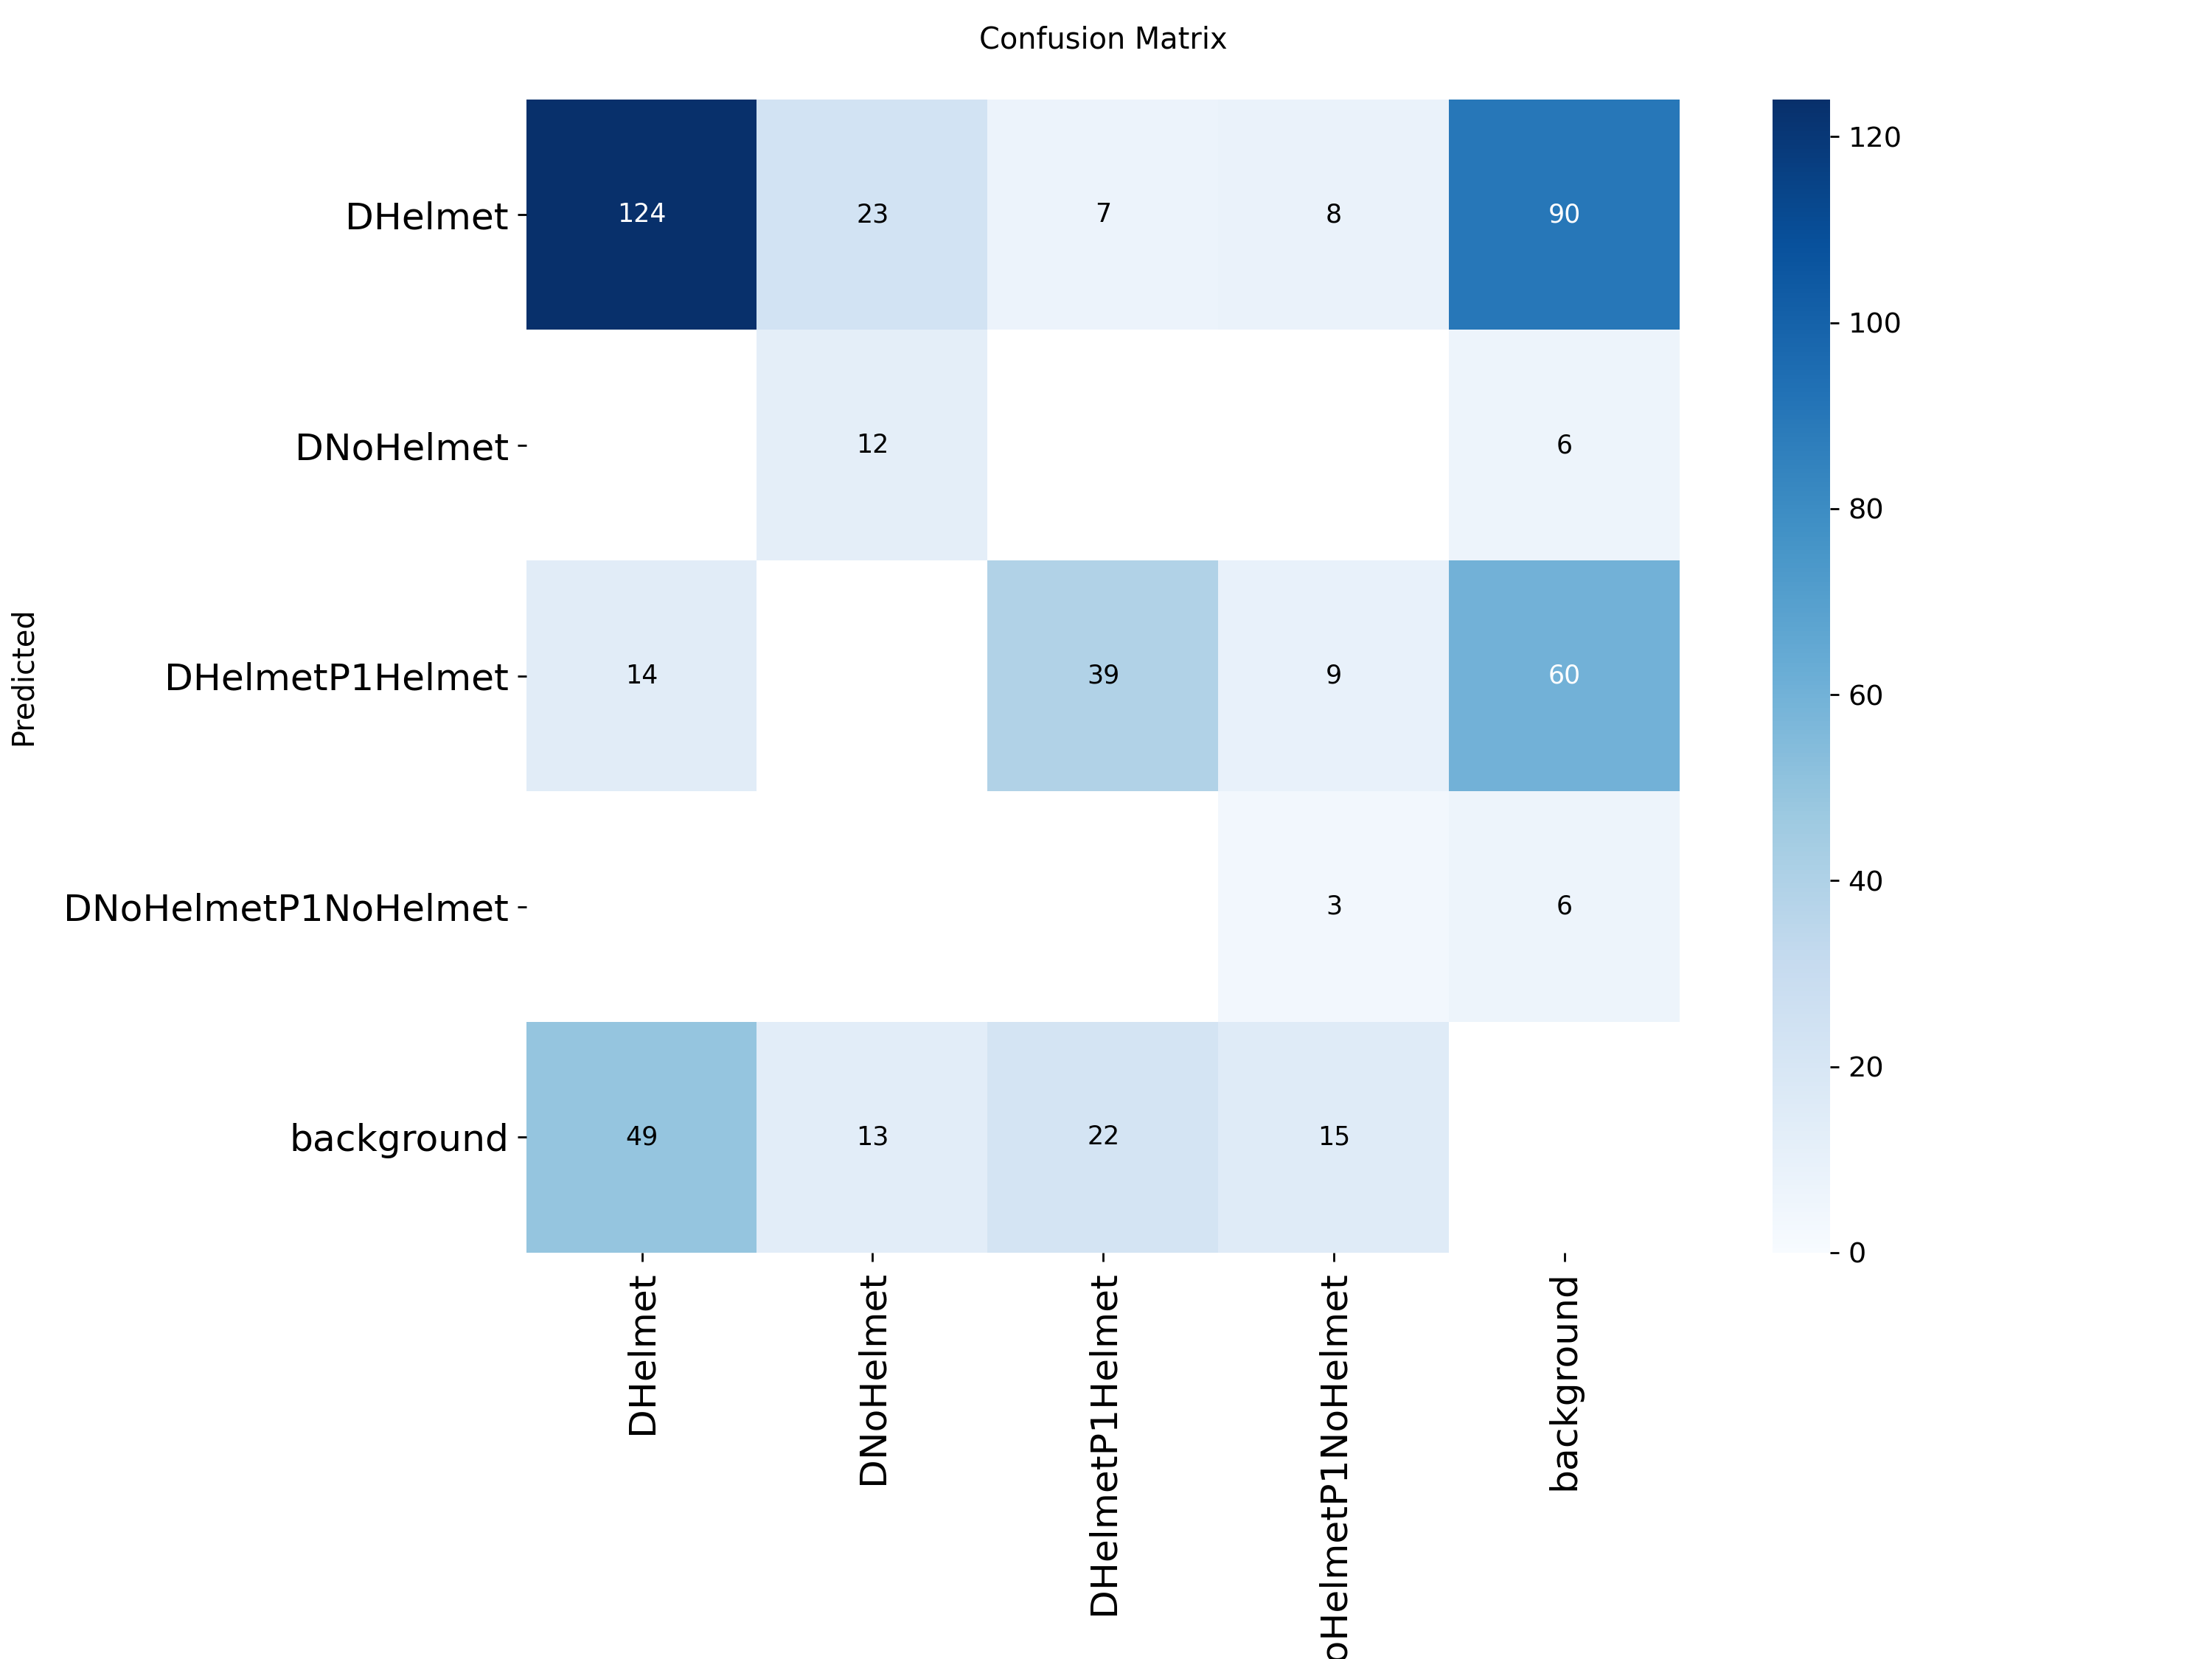

Displaying: BoxF1_curve.png


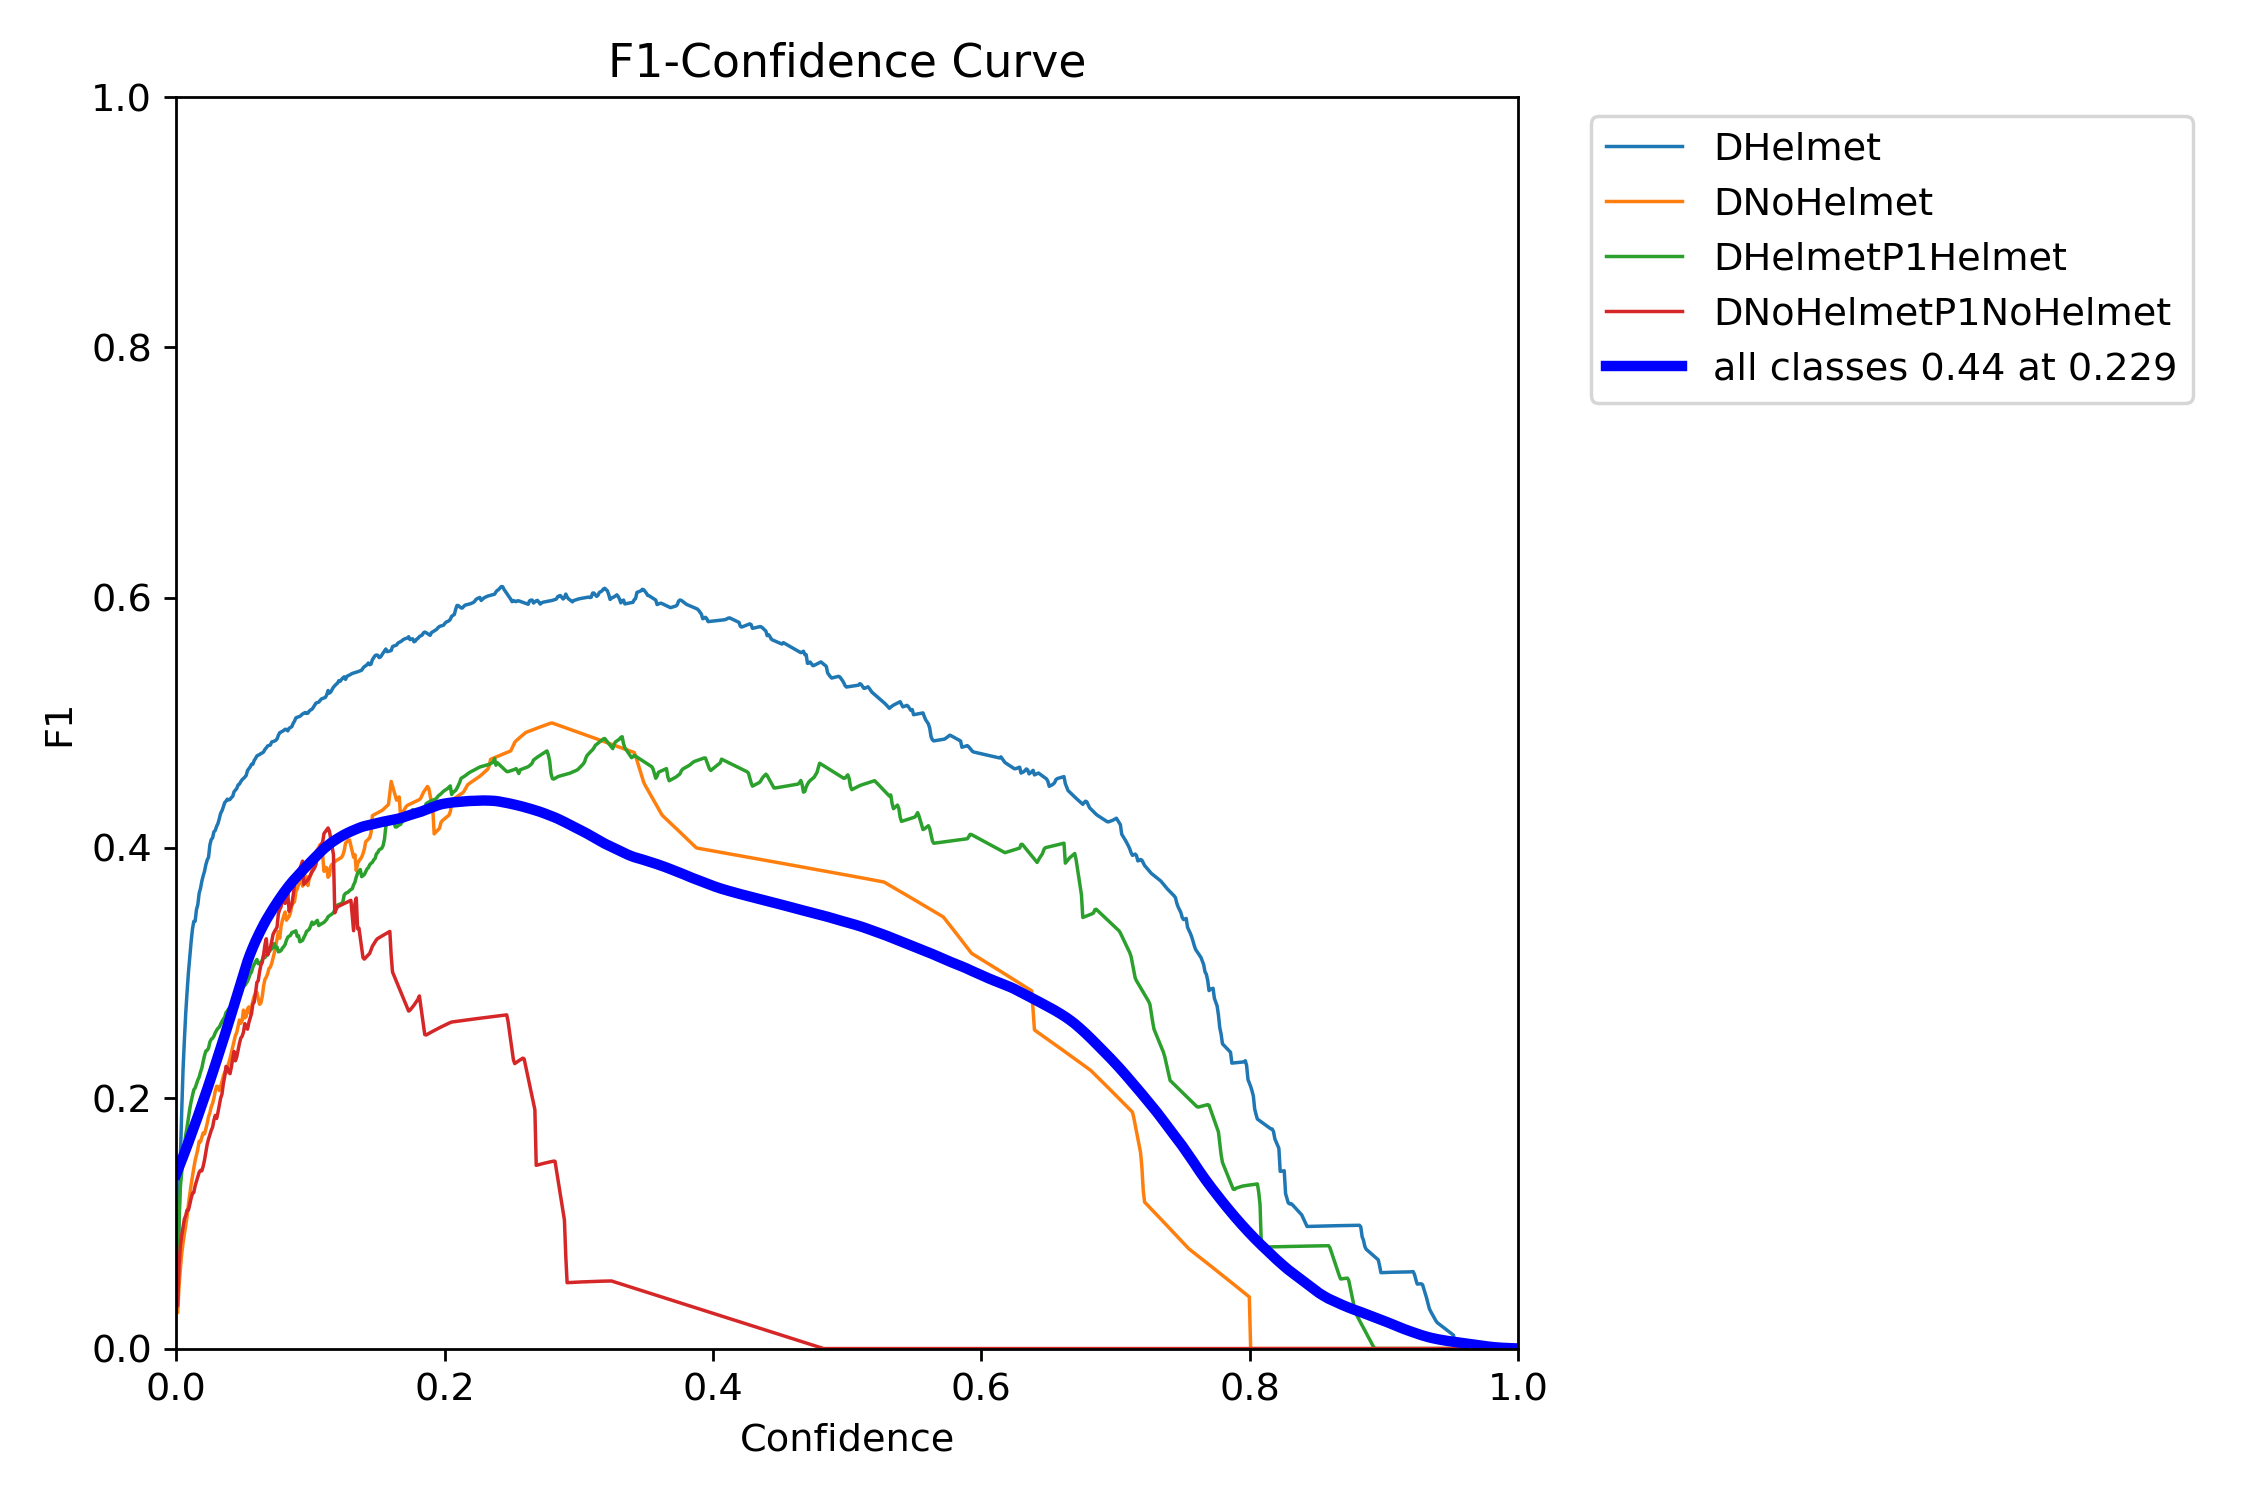

Displaying: BoxP_curve.png


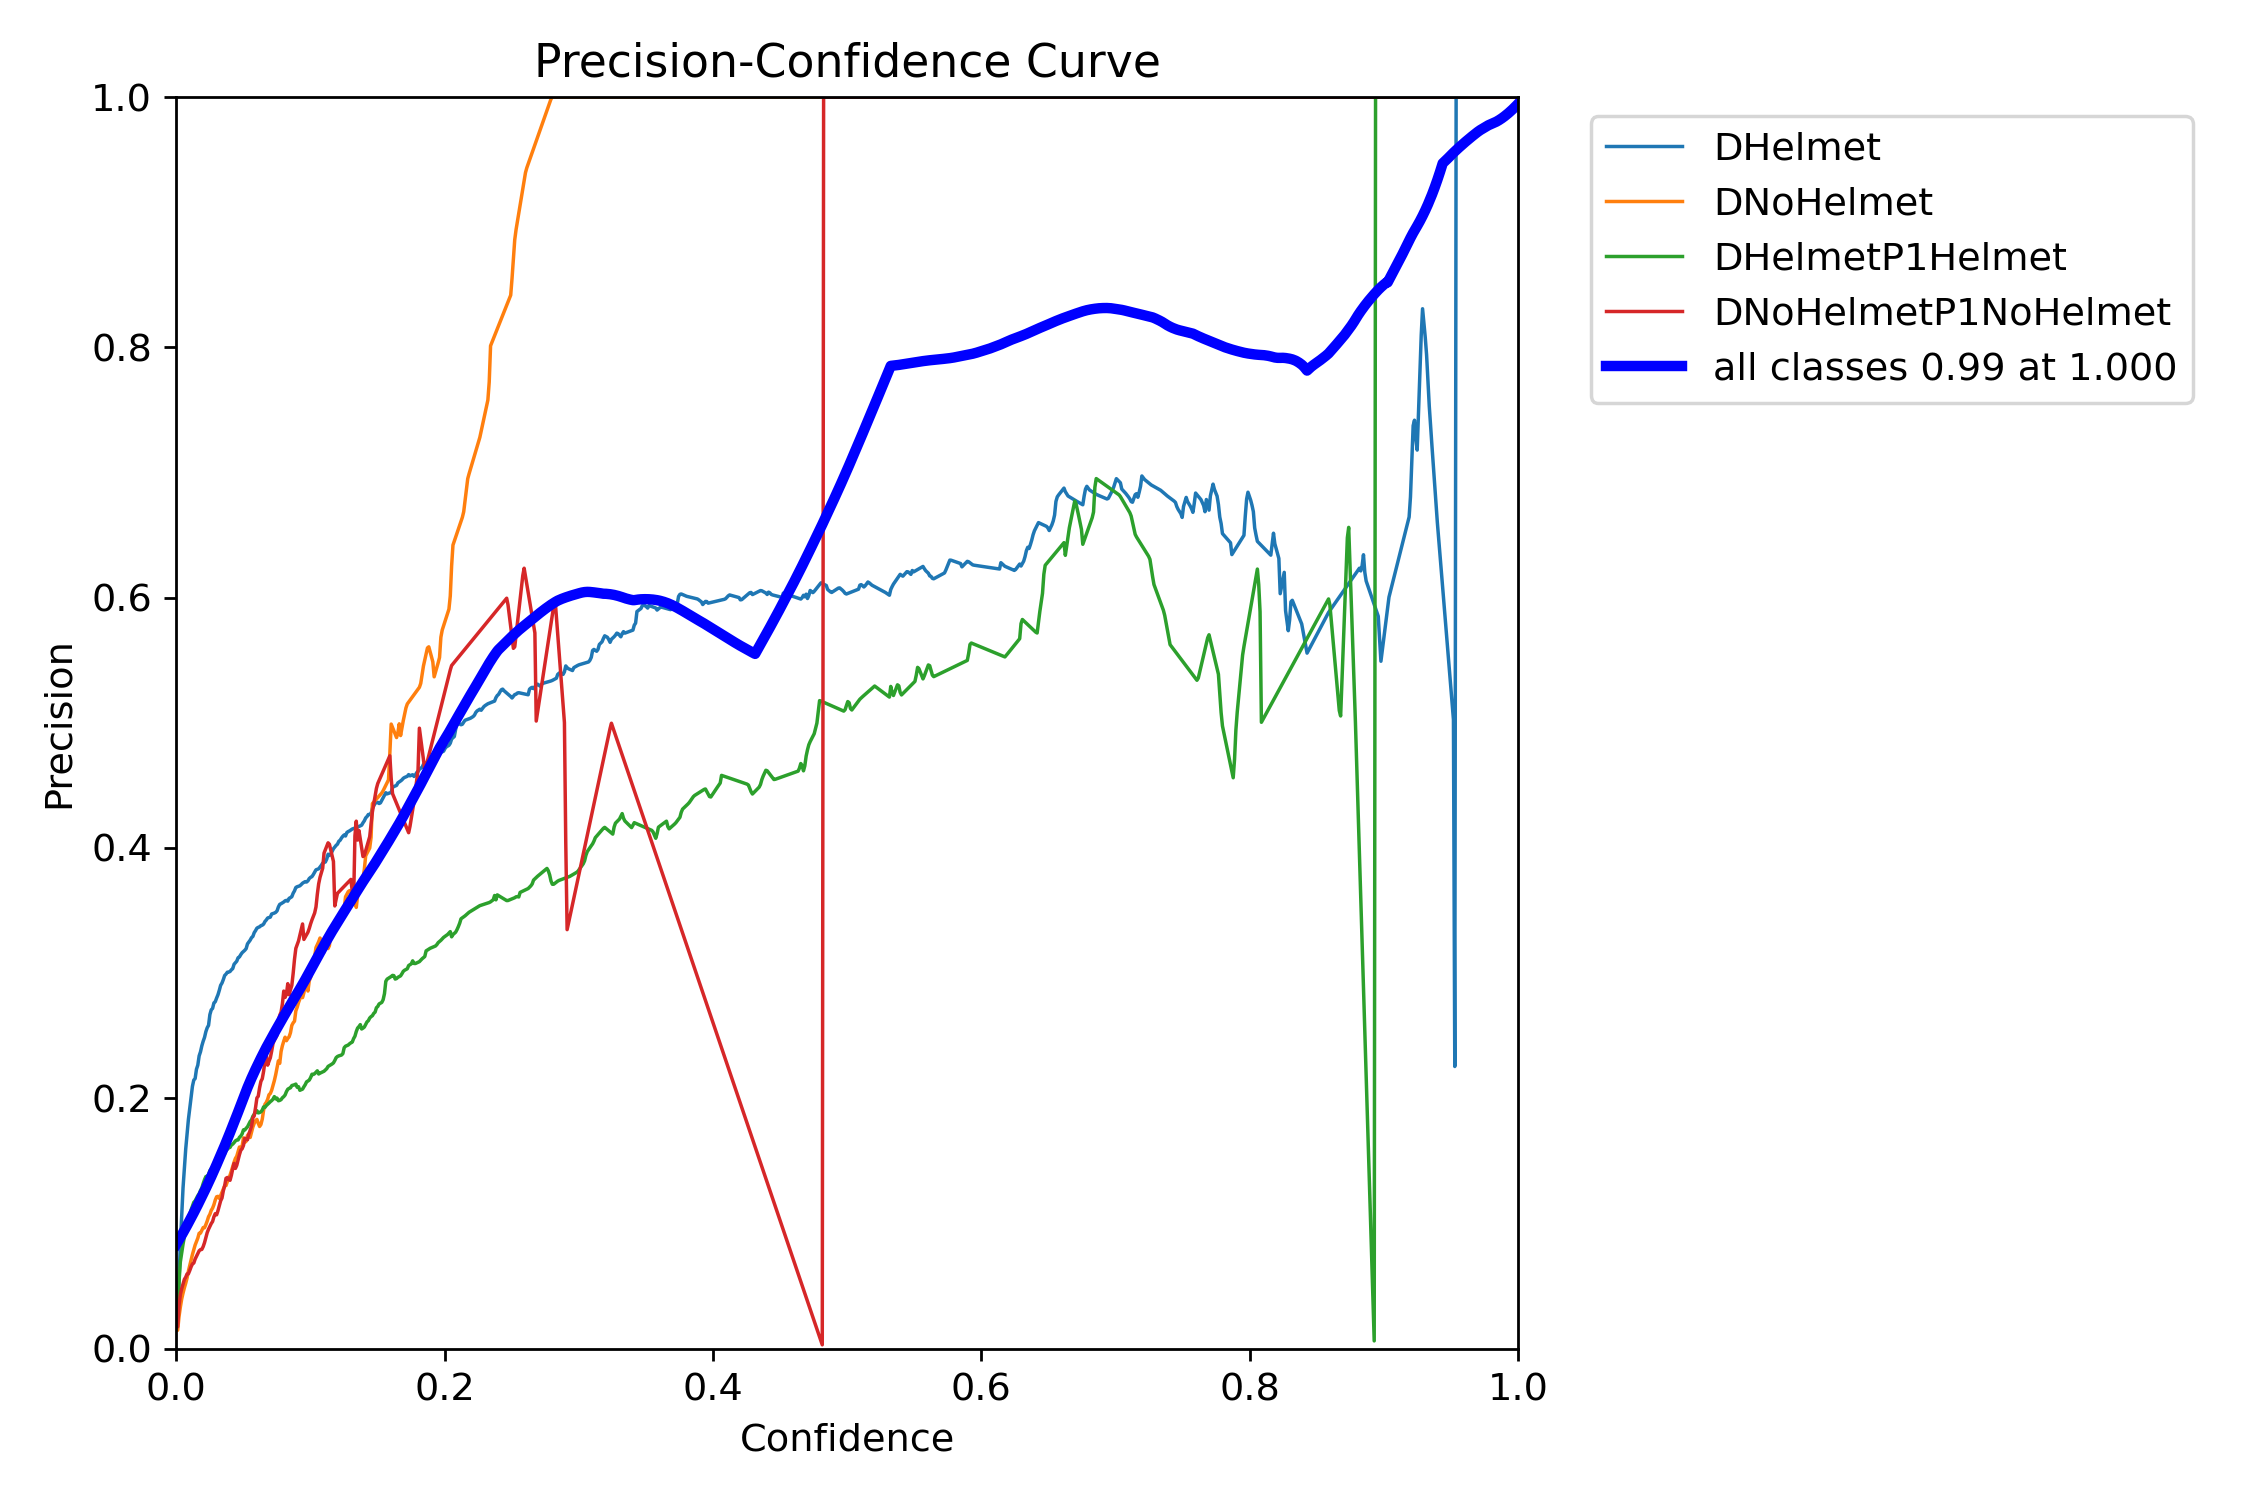

Displaying: BoxR_curve.png


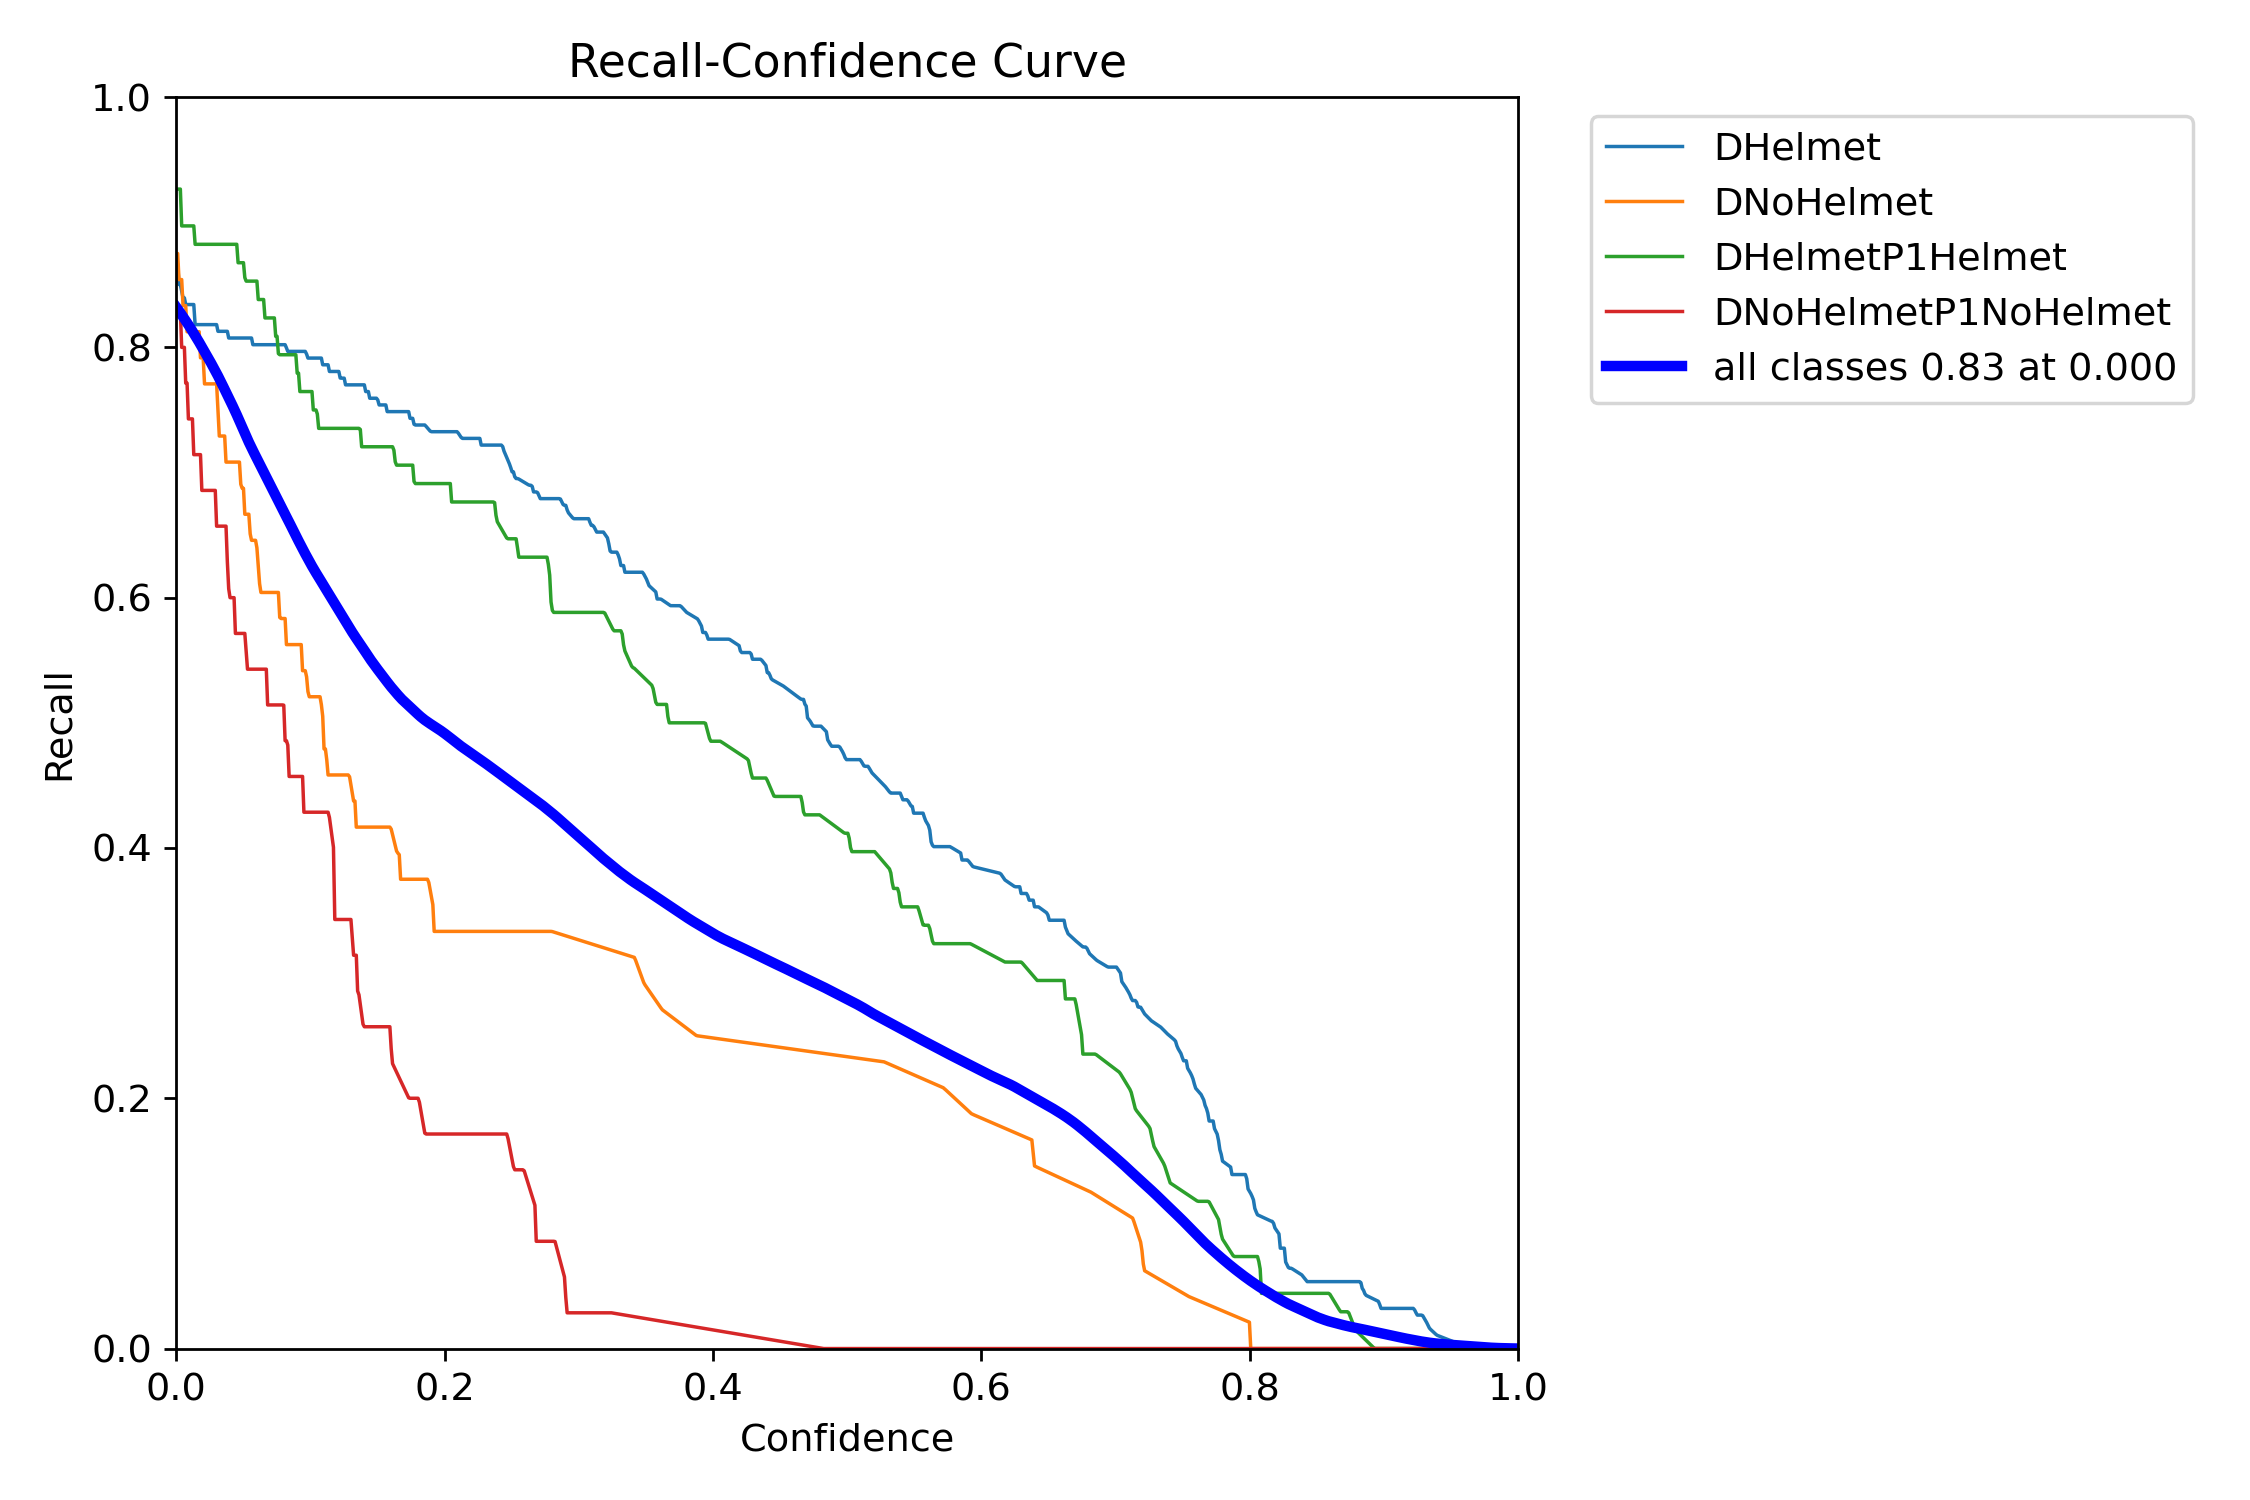

Displaying: BoxPR_curve.png


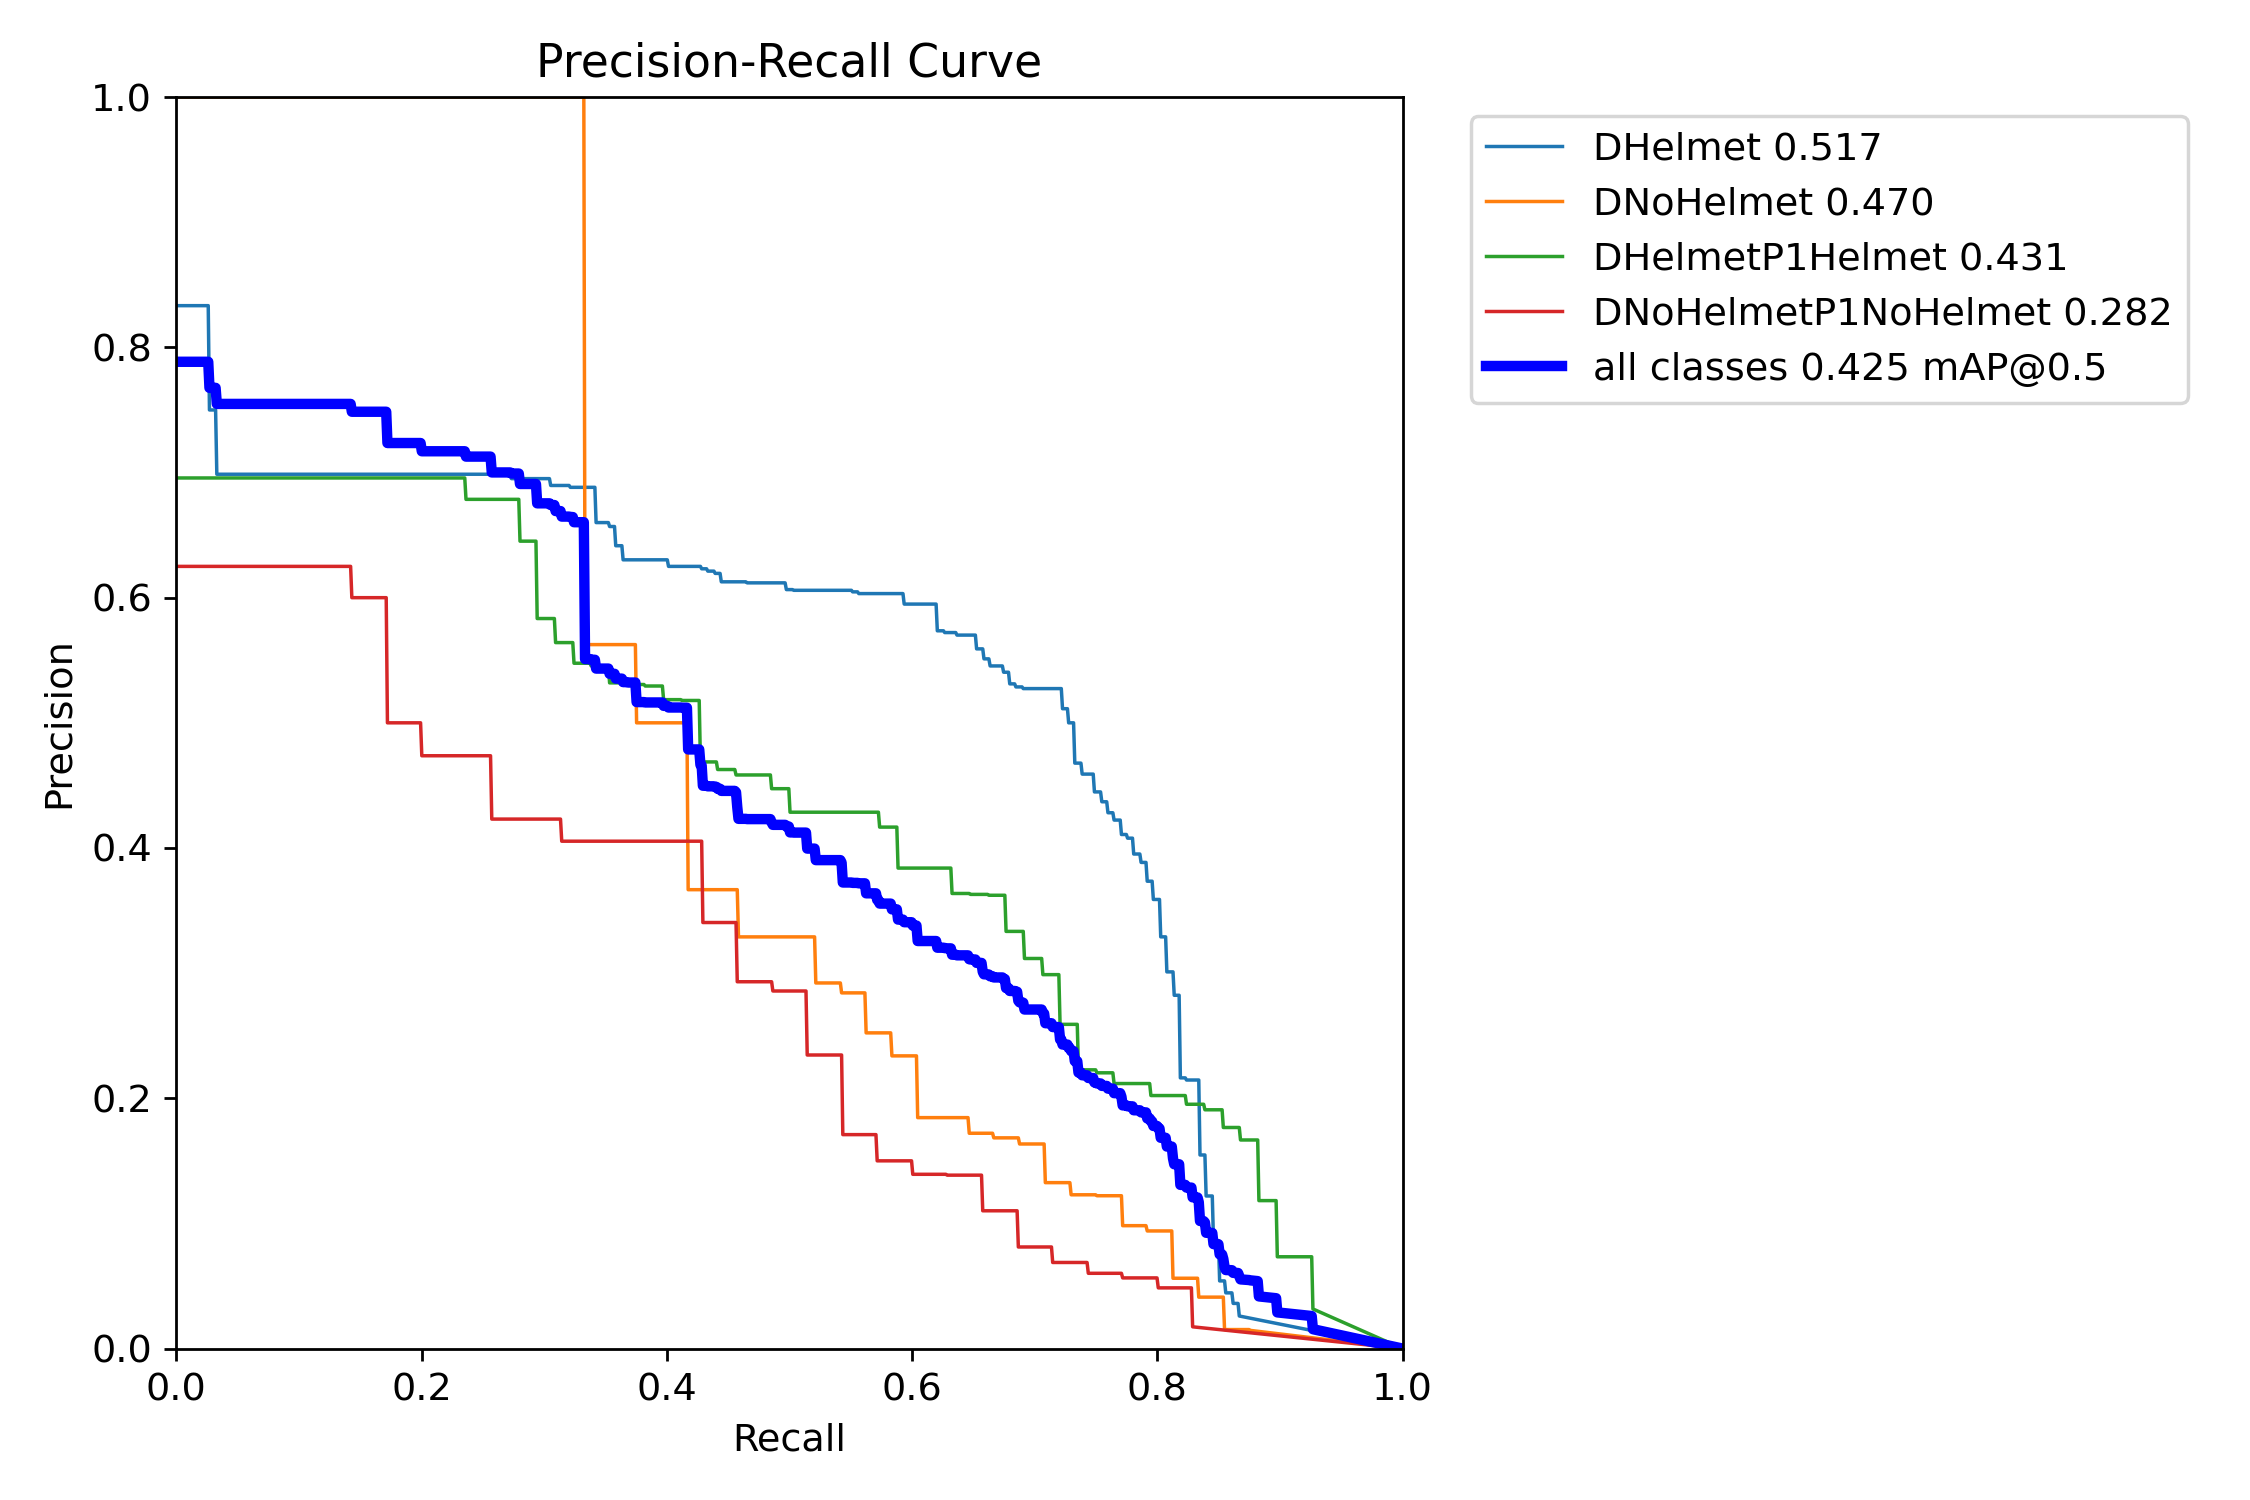

'\nPrecision answers the question:\n=> "Of all the items the model labeled as positive, how many were actually positive?"\n    It focuses on the accuracy of positive predictions, minimizing false positives.\n\nRecall (also known as sensitivity) answers the question:\n=> "Of all the actual positive instances, how many did the model correctly identify?"\n    It emphasizes finding all relevant positive instances, minimizing false negatives.\n\nF1-score combines precision and recall into a single metric, providing a balance between them.\n=> It\'s particularly useful when you need to consider both false positives and false negatives\n    and when there\'s a trade-off between precision and recall.\n    The F1-score is the harmonic mean of precision and recall: F1 = 2 * (precision * recall) / (precision + recall)\n'

In [ ]:
from IPython.display import Image, display
import os

# Define the directory where training results are saved
results_dir = '/content/runs/detect/train32/'

# List of performance plots to display
performance_plots = [
    'confusion_matrix.png',
    'BoxF1_curve.png',
    'BoxP_curve.png',
    'BoxR_curve.png',
    'BoxPR_curve.png'
]

# Display each plot
for plot_name in performance_plots:
    plot_path = os.path.join(results_dir, plot_name)
    if os.path.exists(plot_path):
        print(f"Displaying: {plot_name}")
        display(Image(filename=plot_path))
    else:
        print(f"Plot not found: {plot_name}")

"""
Precision answers the question:
=> "Of all the items the model labeled as positive, how many were actually positive?"
    It focuses on the accuracy of positive predictions, minimizing false positives.

Recall (also known as sensitivity) answers the question:
=> "Of all the actual positive instances, how many did the model correctly identify?"
    It emphasizes finding all relevant positive instances, minimizing false negatives.

F1-score combines precision and recall into a single metric, providing a balance between them.
=> It's particularly useful when you need to consider both false positives and false negatives
    and when there's a trade-off between precision and recall.
    The F1-score is the harmonic mean of precision and recall: F1 = 2 * (precision * recall) / (precision + recall)
"""

In [ ]:
import os
from google.colab import files

# Define the destination path in Google Drive
model_save_path = '/content/drive/My Drive/model/'

# Copy the runs directory to the specified Google Drive path
# Use -r flag for recursive copy and enclose paths in double quotes to handle spaces
#!cp -r "/content/runs/hyperparameter_tuning/train_lr0.01_batch16_imgsz640_optSGD" "{model_save_path}"
!cp -r "/content/runs/detect/val" "{model_save_path}"

print("Model runs successfully copied to Google Drive.")

Model runs successfully copied to Google Drive.


In [ ]:
import os
from google.colab import files

# Zip the runs directory
!zip -r /content/runs.zip /content/runs

# Download the zipped file
files.download('/content/runs.zip')

  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/train6/ (stored 0%)
  adding: content/runs/detect/train6/weights/ (stored 0%)
  adding: content/runs/detect/train6/args.yaml (deflated 52%)
  adding: content/runs/detect/train6/labels.jpg (deflated 30%)
  adding: content/runs/detect/train3/ (stored 0%)
  adding: content/runs/detect/train3/weights/ (stored 0%)
  adding: content/runs/detect/train3/args.yaml (deflated 52%)
  adding: content/runs/detect/train3/labels.jpg (deflated 30%)
  adding: content/runs/detect/train5/ (stored 0%)
  adding: content/runs/detect/train5/weights/ (stored 0%)
  adding: content/runs/detect/train5/args.yaml (deflated 52%)
  adding: content/runs/detect/train5/labels.jpg (deflated 30%)
  adding: content/runs/detect/train2/ (stored 0%)
  adding: content/runs/detect/train2/weights/ (stored 0%)
  adding: content/runs/detect/train2/args.yaml (deflated 52%)
  adding: content/runs/detect/train2/labels.jpg (def

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>